## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Extracting data from csv files

In [26]:
DATA_PATH = os.getcwd()+ '/data/'
IMAGES_PATH = os.getcwd()+ '/images/'
CRASH_REWARD = -1000
AWAY_REWARD = -500
BEST_REWARD = 1000
AVERAGE_EPISODE_COUNT = 40

In [3]:
def read_data(path):
    
    df = pd.read_csv(path)
    data = df.to_numpy().reshape((len(df),))
    return data

In [4]:
def get_concat_average(episodic_rewards_arr):
    
    average_episodic_rewards = []
    episode_reward_list = [episodic_rewards_arr[0]]

    for episodic_reward in episodic_rewards_arr:
        average_episodic_rewards.append(np.mean(episode_reward_list[-AVERAGE_EPISODE_COUNT:]))
        episode_reward_list.append(episodic_reward)

    average_episodic_rewards = np.array(average_episodic_rewards)
    
    return average_episodic_rewards

In [5]:
def get_data(training_names):

    if len(training_names) == 1:
        
        training_name = training_names[0]
        
        rewards = read_data(DATA_PATH + training_names[0] + '_rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '_steps.csv')
        episodic_rewards = read_data(DATA_PATH + training_names[0] + '_episodic_rewards.csv')
        average_episodic_rewards = read_data(DATA_PATH + training_names[0] + '_average_episodic_rewards.csv')
        
    elif len(training_names) > 1:
        
        rewards = read_data(DATA_PATH + training_names[0] + '_rewards.csv')
        steps = read_data(DATA_PATH + training_names[0] + '_steps.csv')
        episodic_rewards = read_data(DATA_PATH + training_names[0] + '_episodic_rewards.csv')
        
        for i in range(1,len(training_names)):
            rewards = np.concatenate((rewards, read_data(DATA_PATH + training_names[i] + '_rewards.csv'))) 
            steps = np.concatenate((steps, steps[-1] + read_data(DATA_PATH + training_names[i] + '_steps.csv')))
            episodic_rewards = np.concatenate((episodic_rewards, read_data(DATA_PATH + training_names[i] + '_episodic_rewards.csv')))
            
        average_episodic_rewards = get_concat_average(episodic_rewards)   
            
    data_dict = {
                 'rewards'                  : rewards,
                 'steps'                    : steps,
                 'episodic_rewards'         : episodic_rewards,
                 'average_episodic_rewards' : average_episodic_rewards
                }       

    return data_dict

## Plotting results

In [6]:
from scipy import optimize

def linear_regression(x, a, b):
    return a*x+b

In [24]:
def plot_results(training_name, data_dict, total_episodes, left_index=-51, right_index=-1):

    rewards = data_dict['rewards']
    steps = data_dict['steps']
    episodic_rewards = data_dict['episodic_rewards']
    average_episodic_rewards = data_dict['average_episodic_rewards']
    
    # -------------------------- PLOTTING REWARDS OVER EPISODES -----------------------------
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (20,10), dpi = 120)
    ax = axes.ravel()

    ax[0].plot(np.arange(1,episodic_rewards.shape[0]+1), episodic_rewards, color='orange', linewidth=1.0, label='episodic')
    ax[0].plot(np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, color='darkgreen', linewidth=1.5, label='average episodic')
    
    params = [0, 0]
    params, _ = optimize.curve_fit(linear_regression, np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, params)
    
    ax[0].plot(np.arange(1,average_episodic_rewards.shape[0]+1), linear_regression(np.arange(1,average_episodic_rewards.shape[0]+1), *params), color='blue', linewidth=1.2, linestyle='--', label='fitted line')
    ax[0].grid()
    ax[0].set_xlabel('Episode', fontsize=16)
    ax[0].set_ylabel('Rt', fontsize=16)
    ax[0].set_title('Episodic and Average Episodic Reward \n(averaged every {} episodes)'.format(AVERAGE_EPISODE_COUNT), fontsize=16)
    ax[0].legend(loc='upper left')

    ax[1].plot(np.arange(1,episodic_rewards.shape[0]+1), np.log(1+abs(min(episodic_rewards))+episodic_rewards), color='orange', linewidth=1.0, label='episodic')
    ax[1].plot(np.arange(1,average_episodic_rewards.shape[0]+1), np.log(1+abs(min(average_episodic_rewards))+average_episodic_rewards), color='darkgreen', linewidth=1.5, label='average episodic')
    
    params = [0, 0]
    params, _ = optimize.curve_fit(linear_regression, np.arange(1,average_episodic_rewards.shape[0]+1), np.log(1+abs(min(average_episodic_rewards))+average_episodic_rewards), params)
    
    ax[1].plot(np.arange(1,average_episodic_rewards.shape[0]+1), linear_regression(np.arange(1,average_episodic_rewards.shape[0]+1), *params), color='blue', linewidth=1.2, linestyle='--', label='fitted line')
    ax[1].grid()
    ax[1].set_xlabel('Episode', fontsize=16)
    ax[1].set_ylabel('log(Rt)', fontsize=16)
    ax[1].set_title('Log of Episodic and Average Episodic Reward \n(averaged every {} episodes)'.format(AVERAGE_EPISODE_COUNT), fontsize=16)
    ax[1].legend(loc='upper left')

    plt.suptitle('Training name : ' + training_name, fontsize=18)
    plt.tight_layout()
    plt.show()

    fig.savefig(IMAGES_PATH + training_name + '_episodic_and_average_rewards', facecolor = 'white', bbox_inches='tight')
    
    
    # -------------------------- PLOTTING REWARDS OVER SOME ITERATIONS -----------------------------

    left_index_for_title = left_index+1 if left_index >= 0 else total_episodes+left_index+1
    right_index_for_title = right_index+1 if right_index >= 0 else total_episodes+right_index+1

    last_episodes_rewards = rewards[steps[left_index]:steps[right_index]]

    fig = plt.figure(figsize=(20,10), dpi=120)
    plt.plot(np.arange(steps[left_index],steps[right_index]), last_episodes_rewards, color='blue', label='iteration reward')

    for step in steps[left_index:right_index]:
        if step == steps[right_index-1]:
            plt.axvline(step,color='tomato', linestyle='--', label='end of episode')
        else:
            plt.axvline(step,color='tomato', linestyle='--')

    plt.axhline(BEST_REWARD, color='green', label='best reward')
    plt.axhline(CRASH_REWARD, color='darkred', label='crash reward')
    plt.axhline(AWAY_REWARD, color='red', label='away reward')
    plt.title('Iteration rewards from {:d}. to {:d}. episode'.format(left_index_for_title, right_index_for_title), fontsize=16)
    plt.xlabel('#No. Iteration', fontsize=16)
    plt.ylabel('Rt', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid()

    plt.suptitle('Training name : ' + training_name, fontsize=18)
    plt.tight_layout()
    plt.show()

    fig.savefig(IMAGES_PATH + training_name + '_iteration_rewards', facecolor = 'white', bbox_inches='tight')

### 6th training results

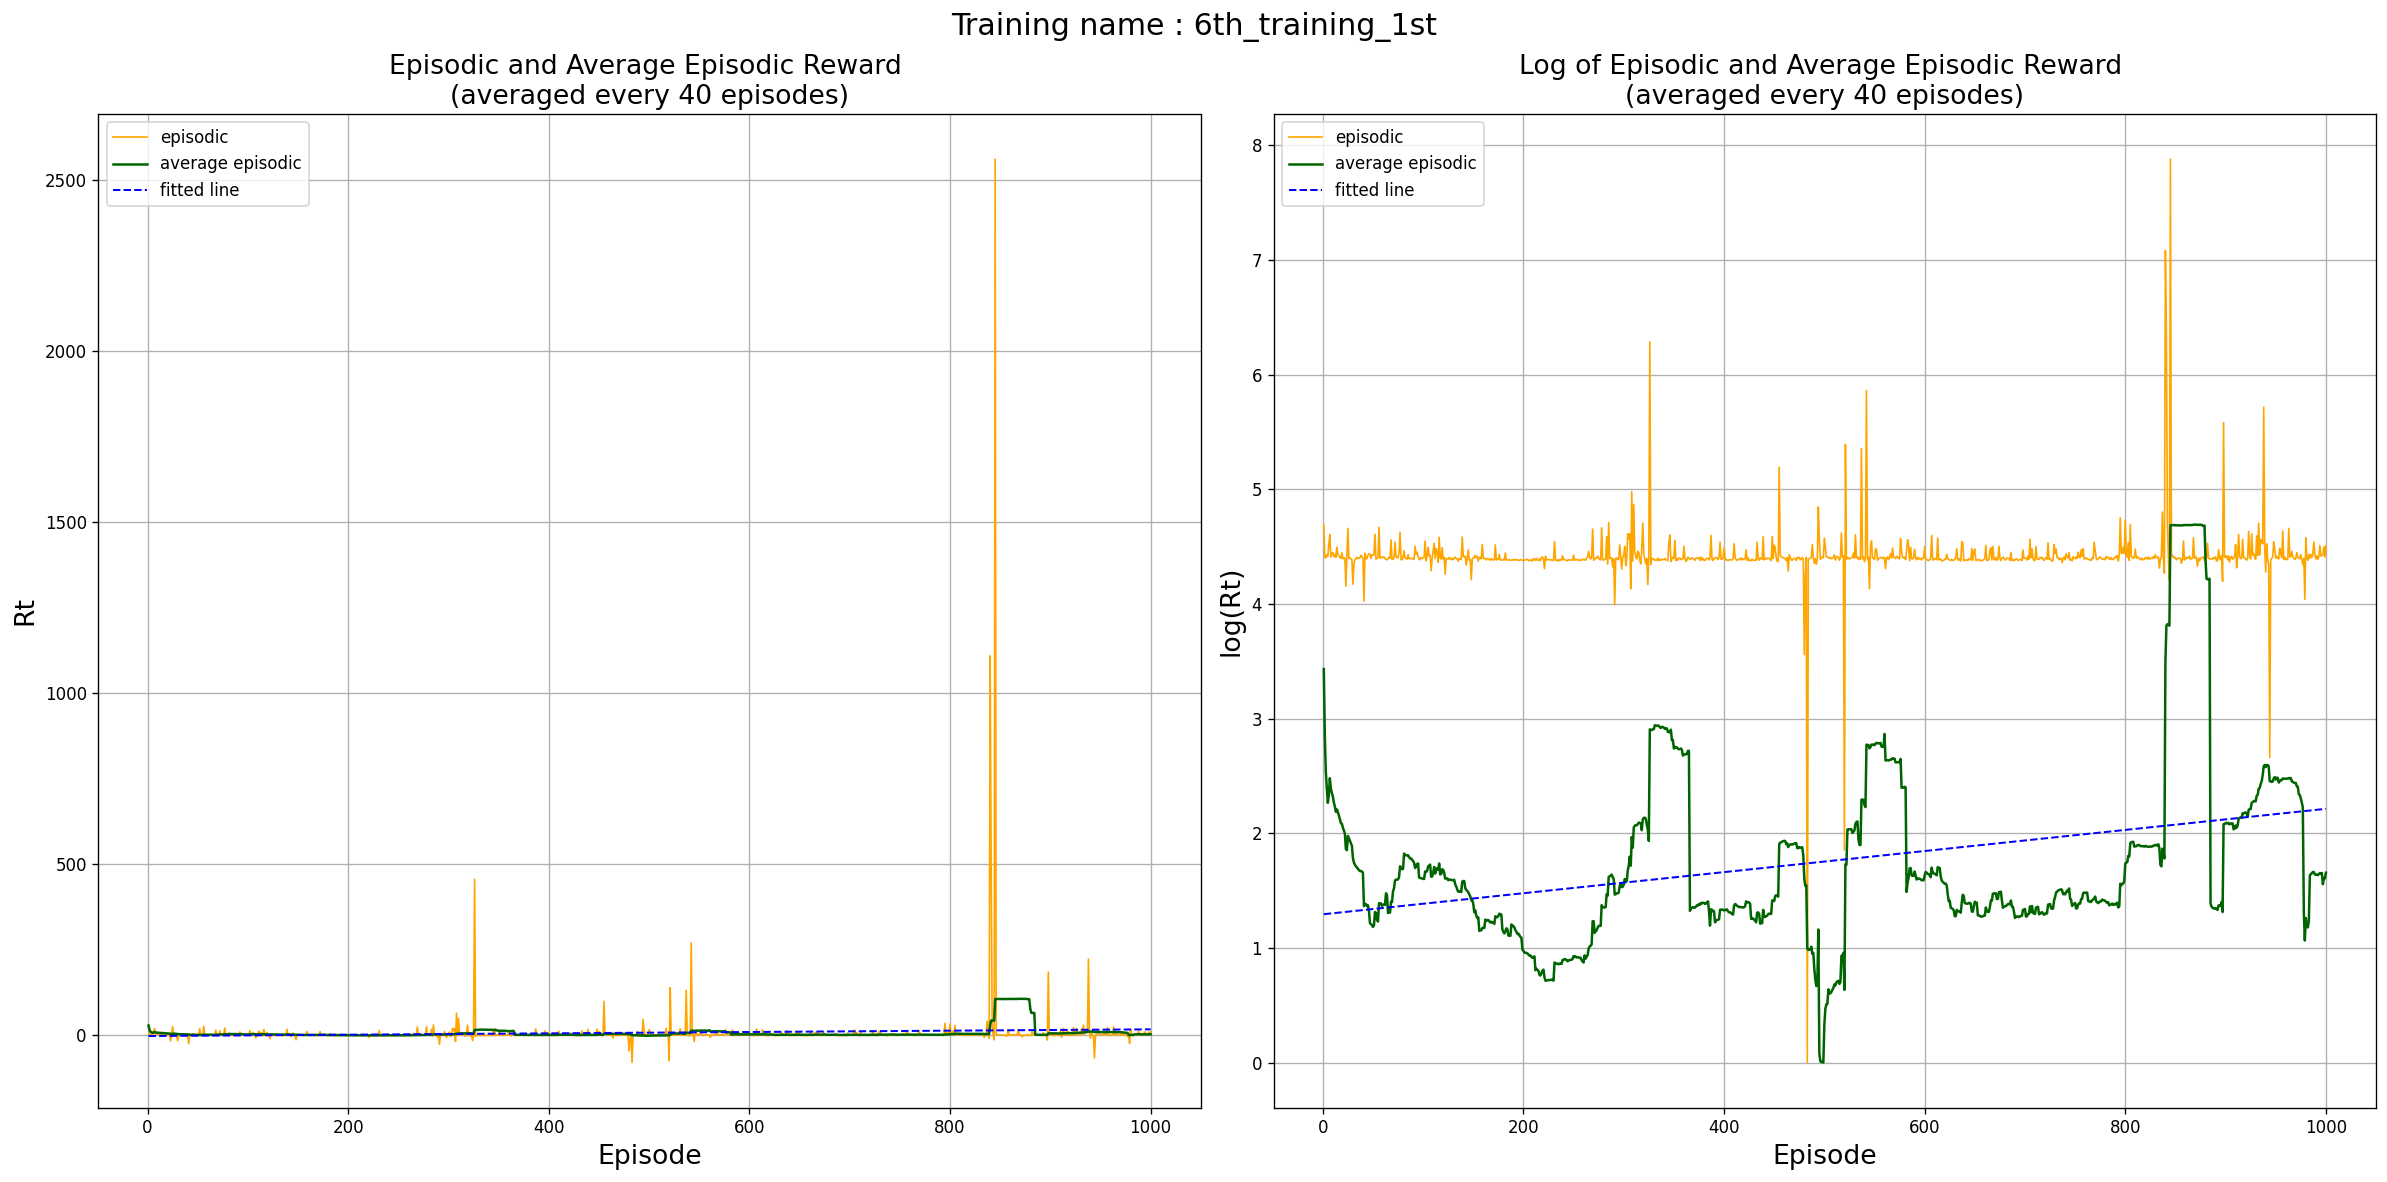

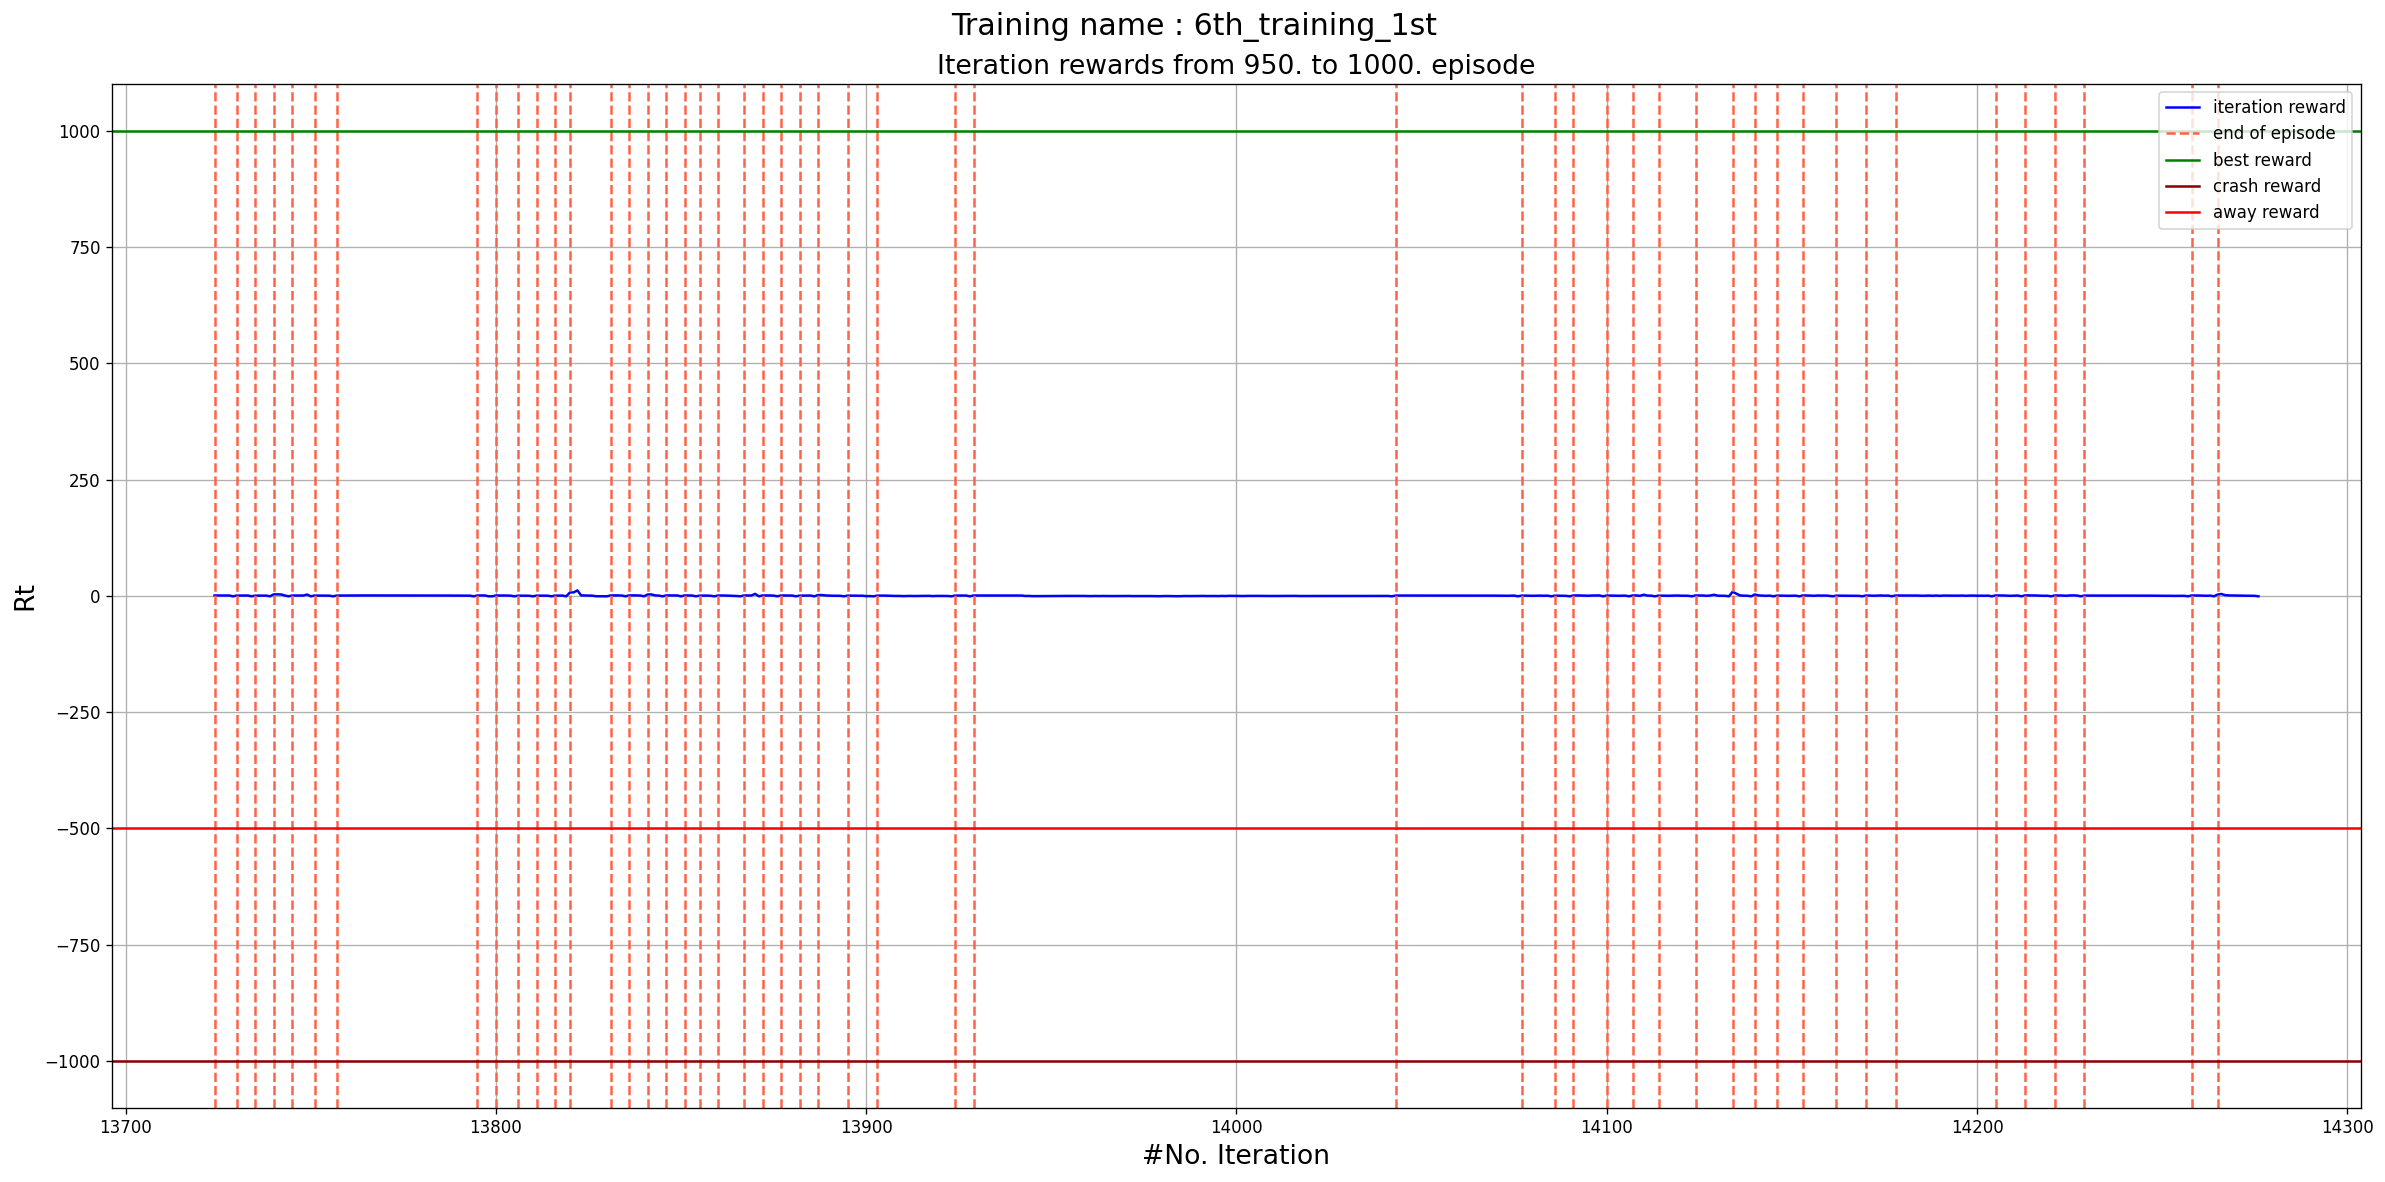

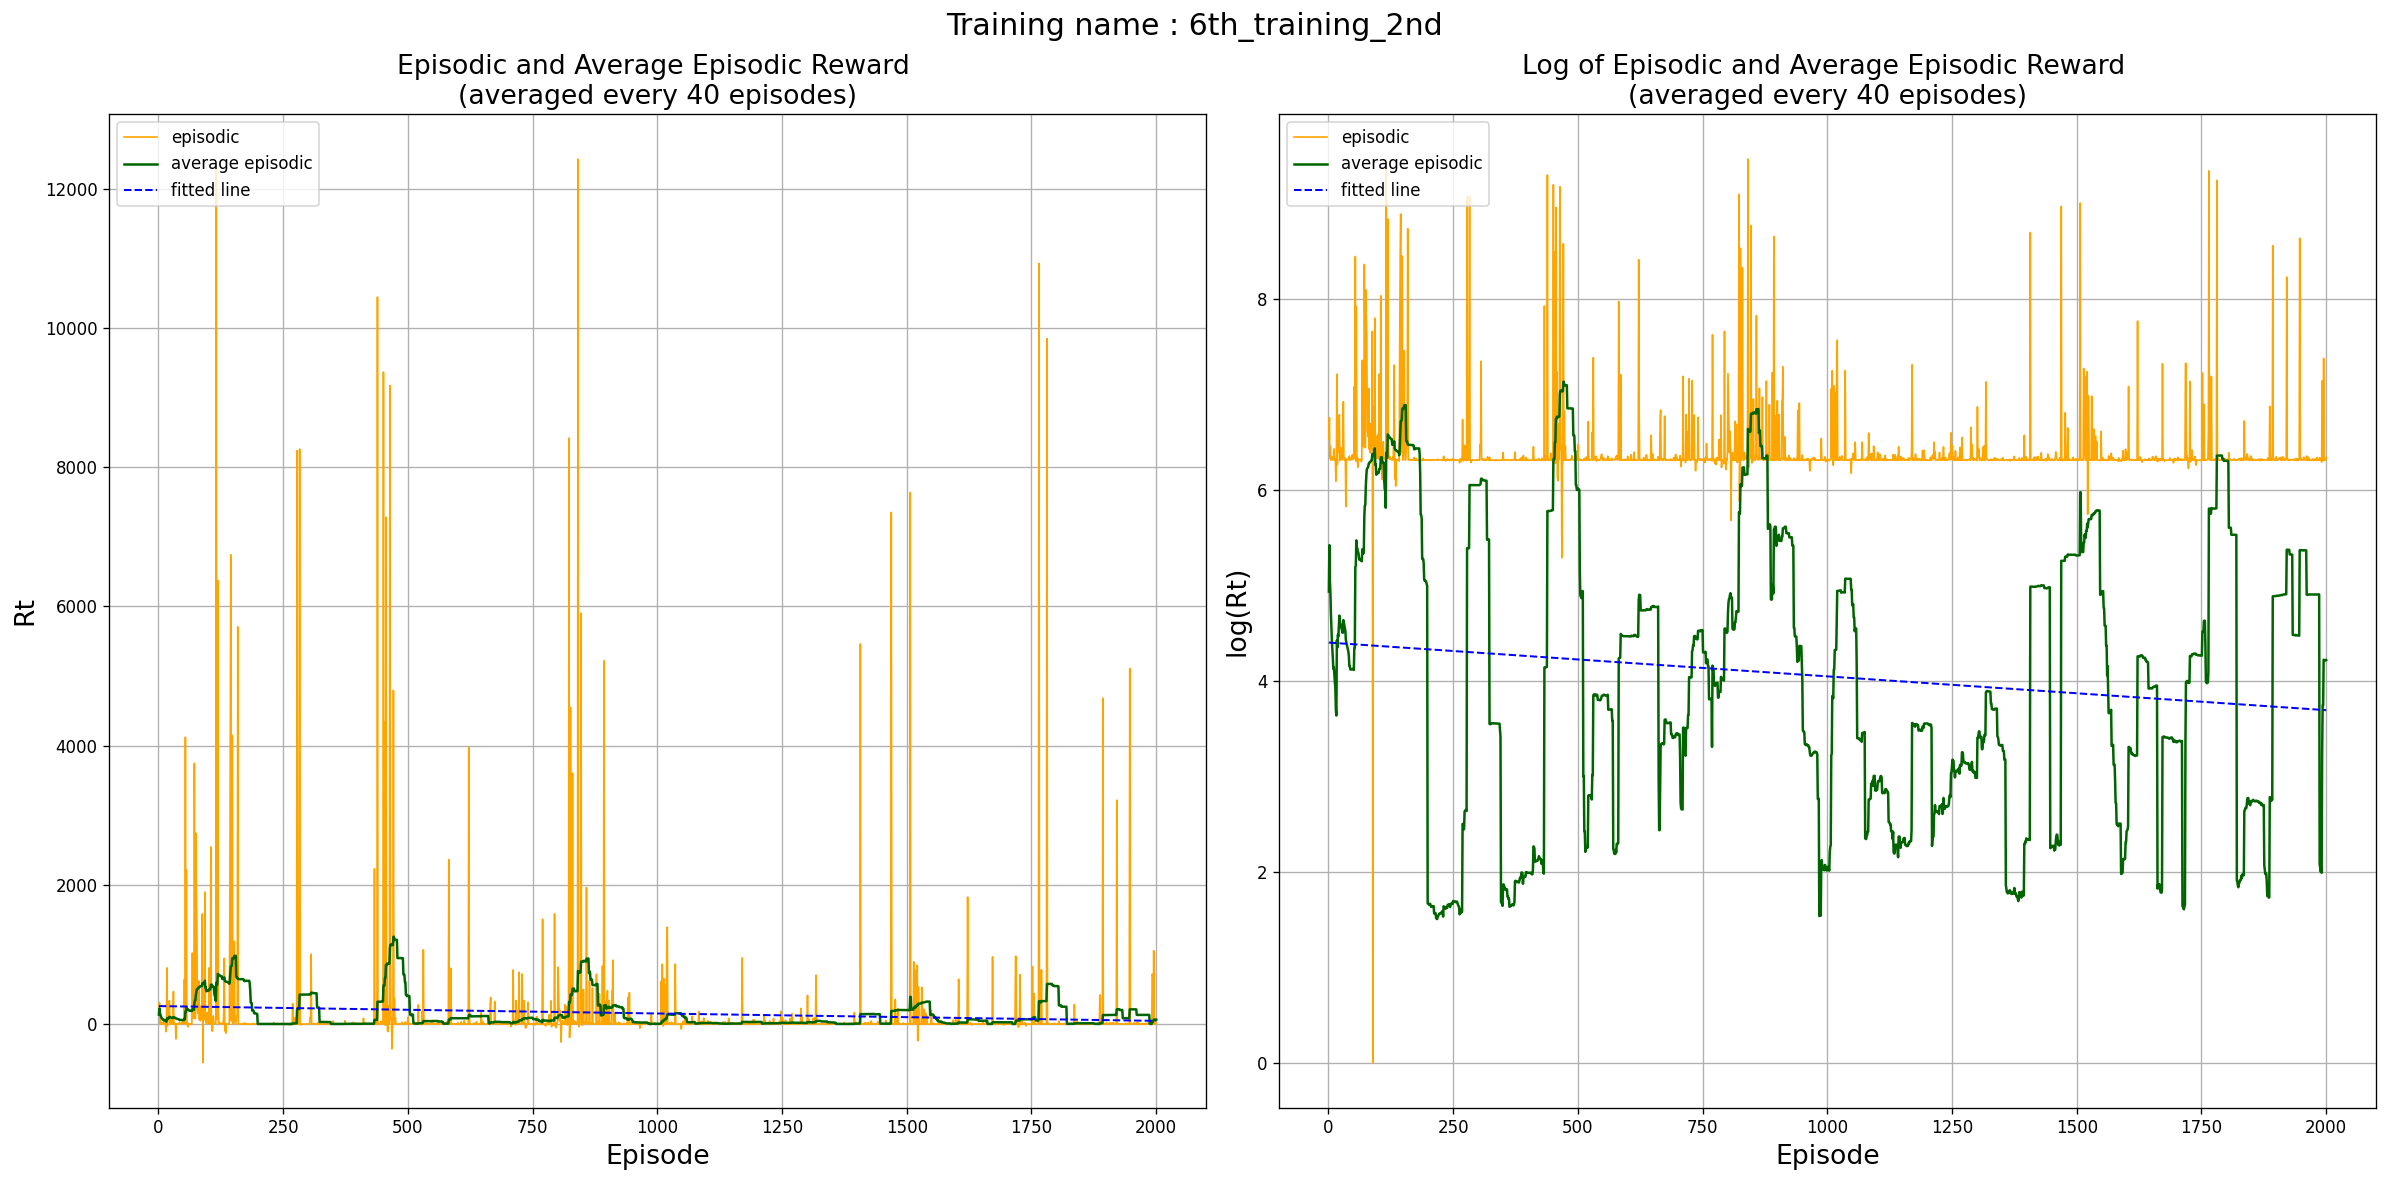

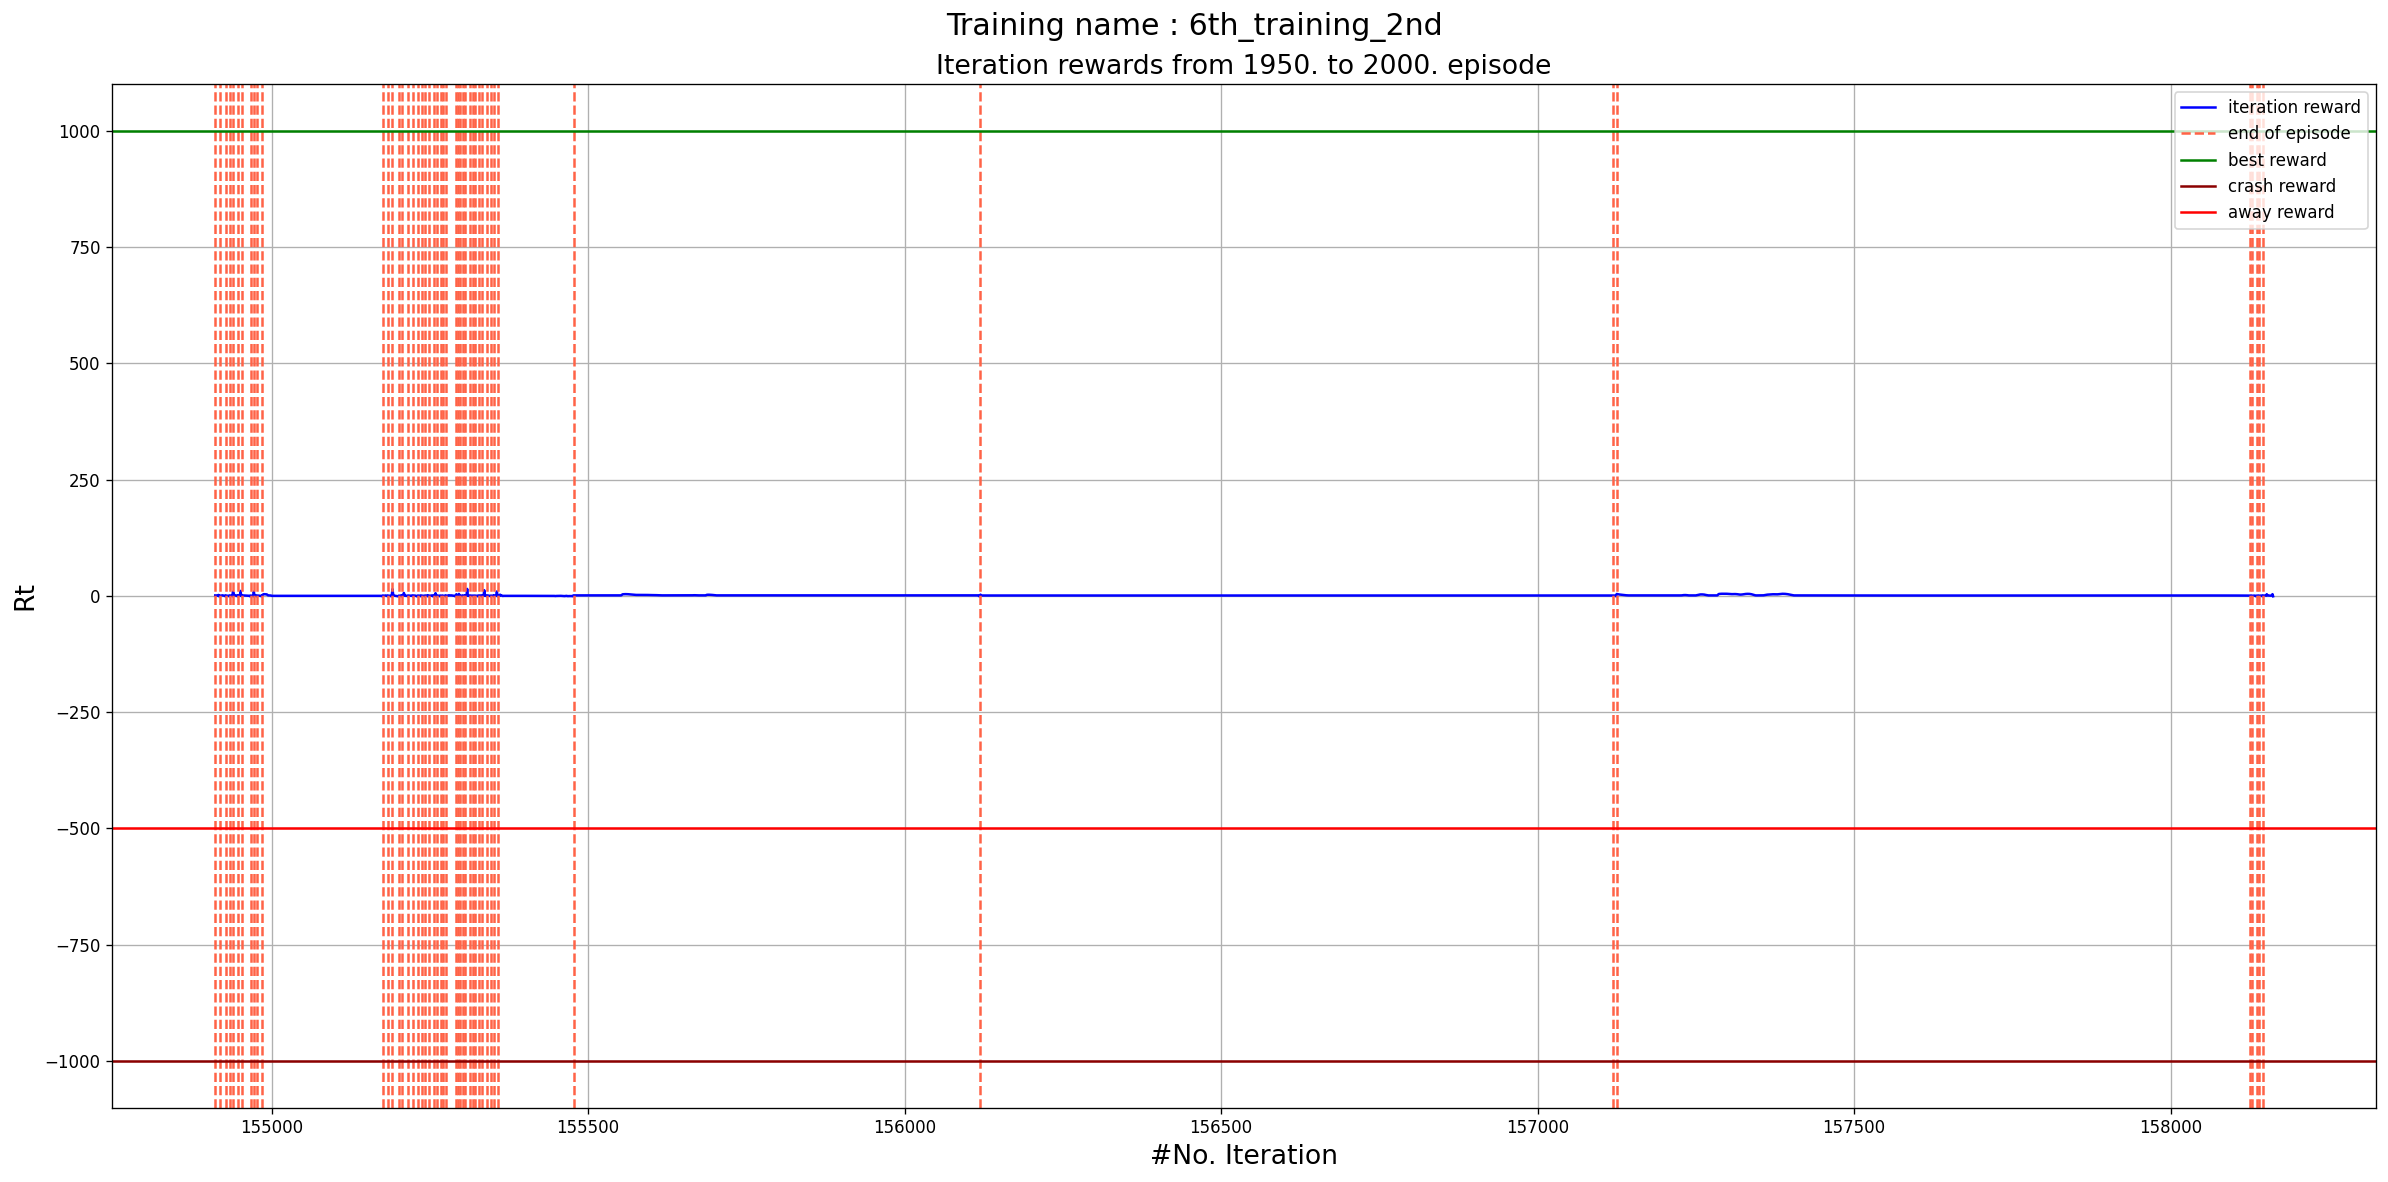

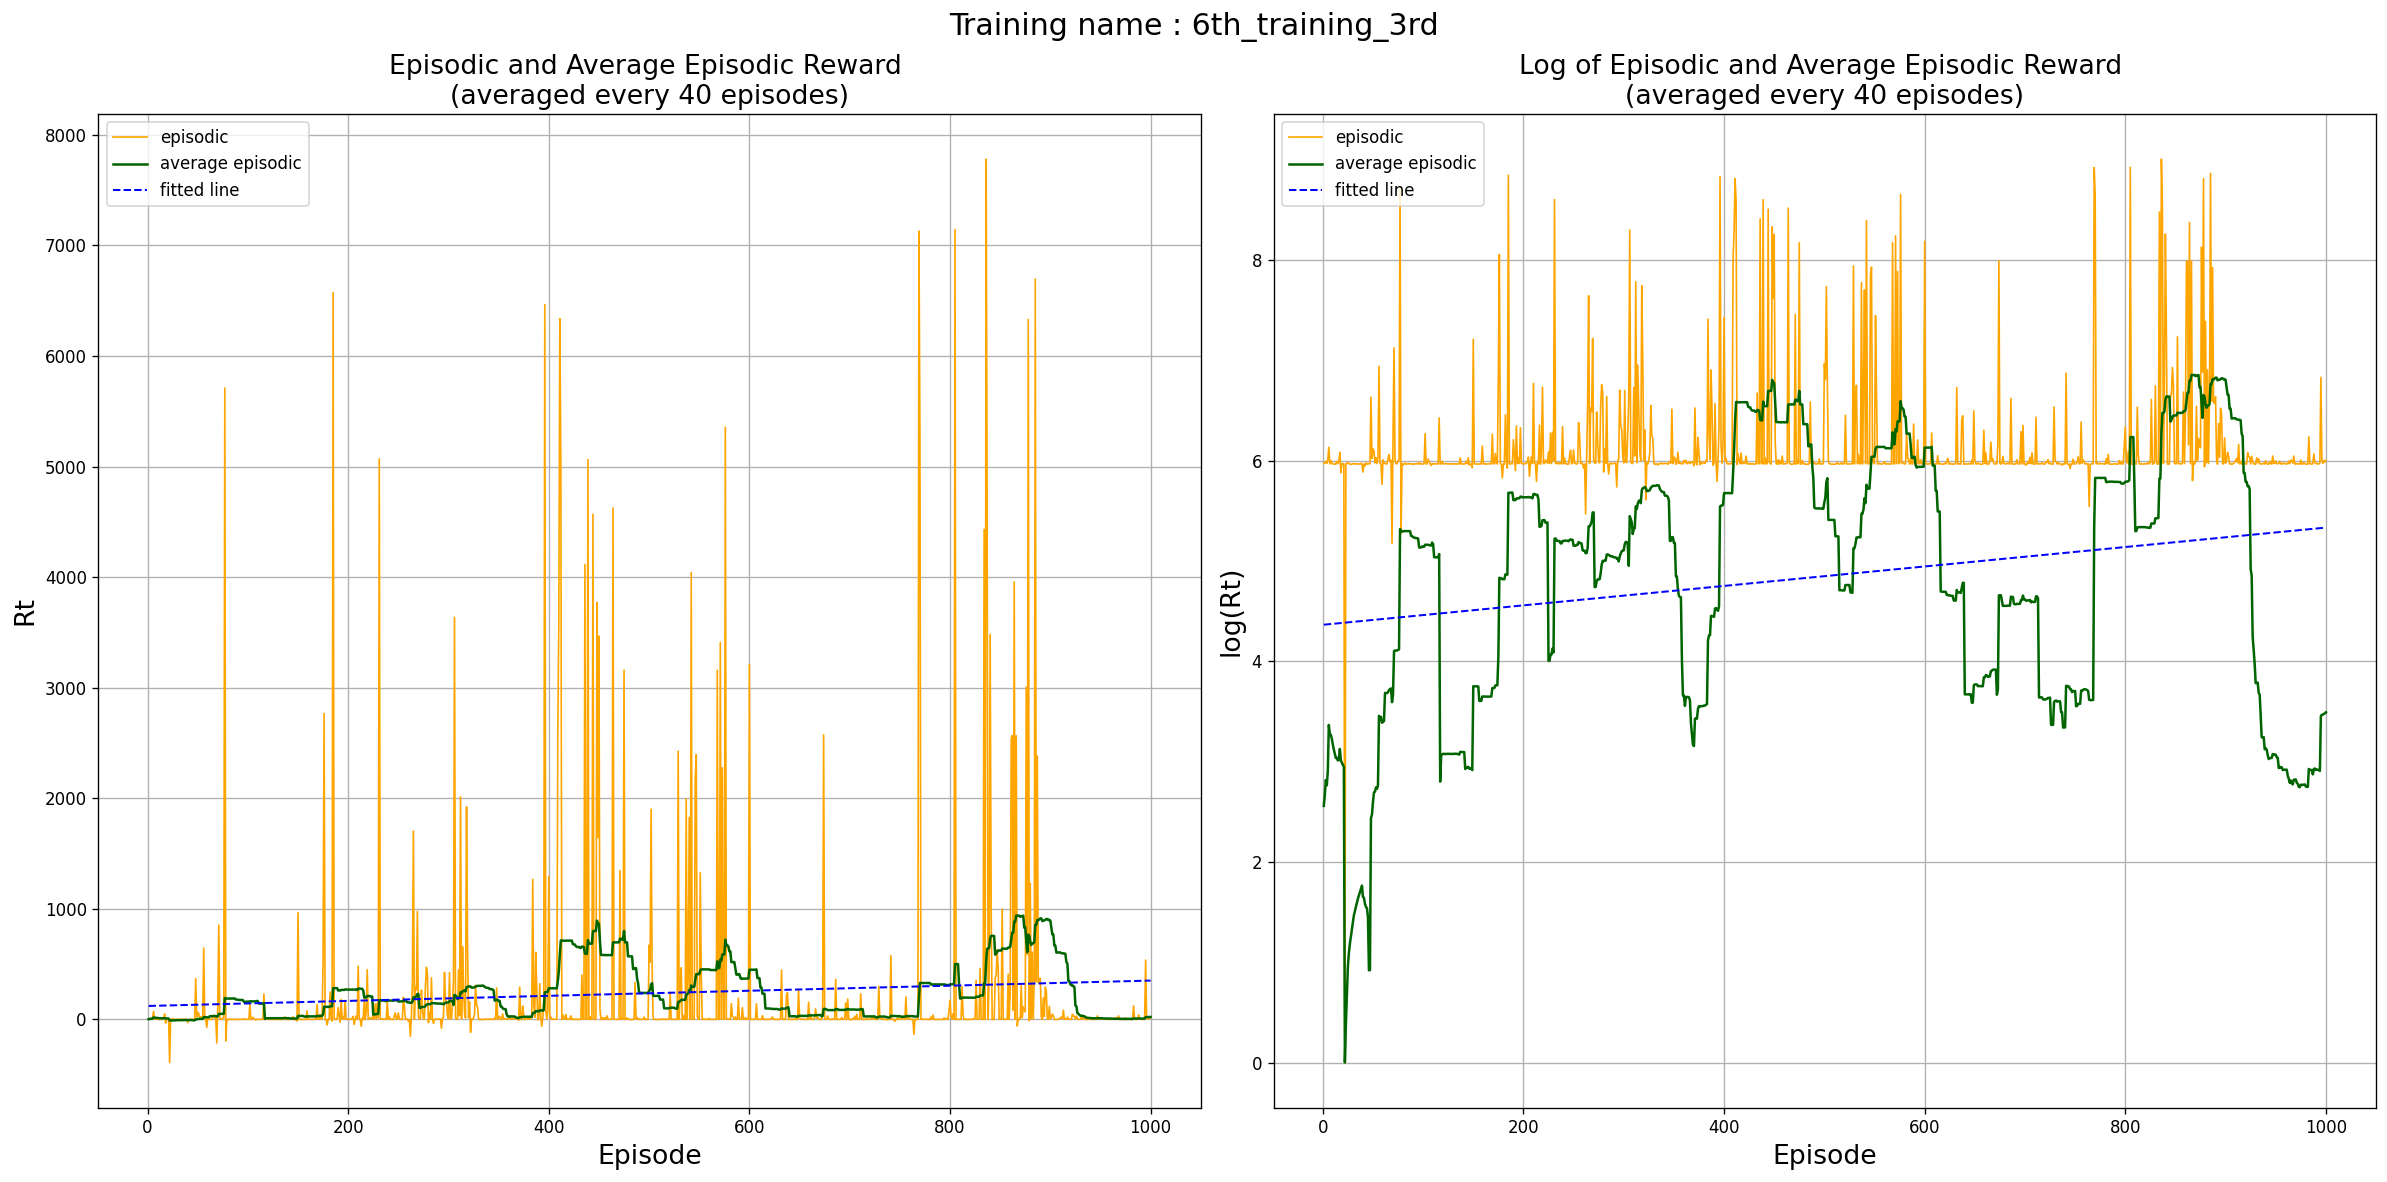

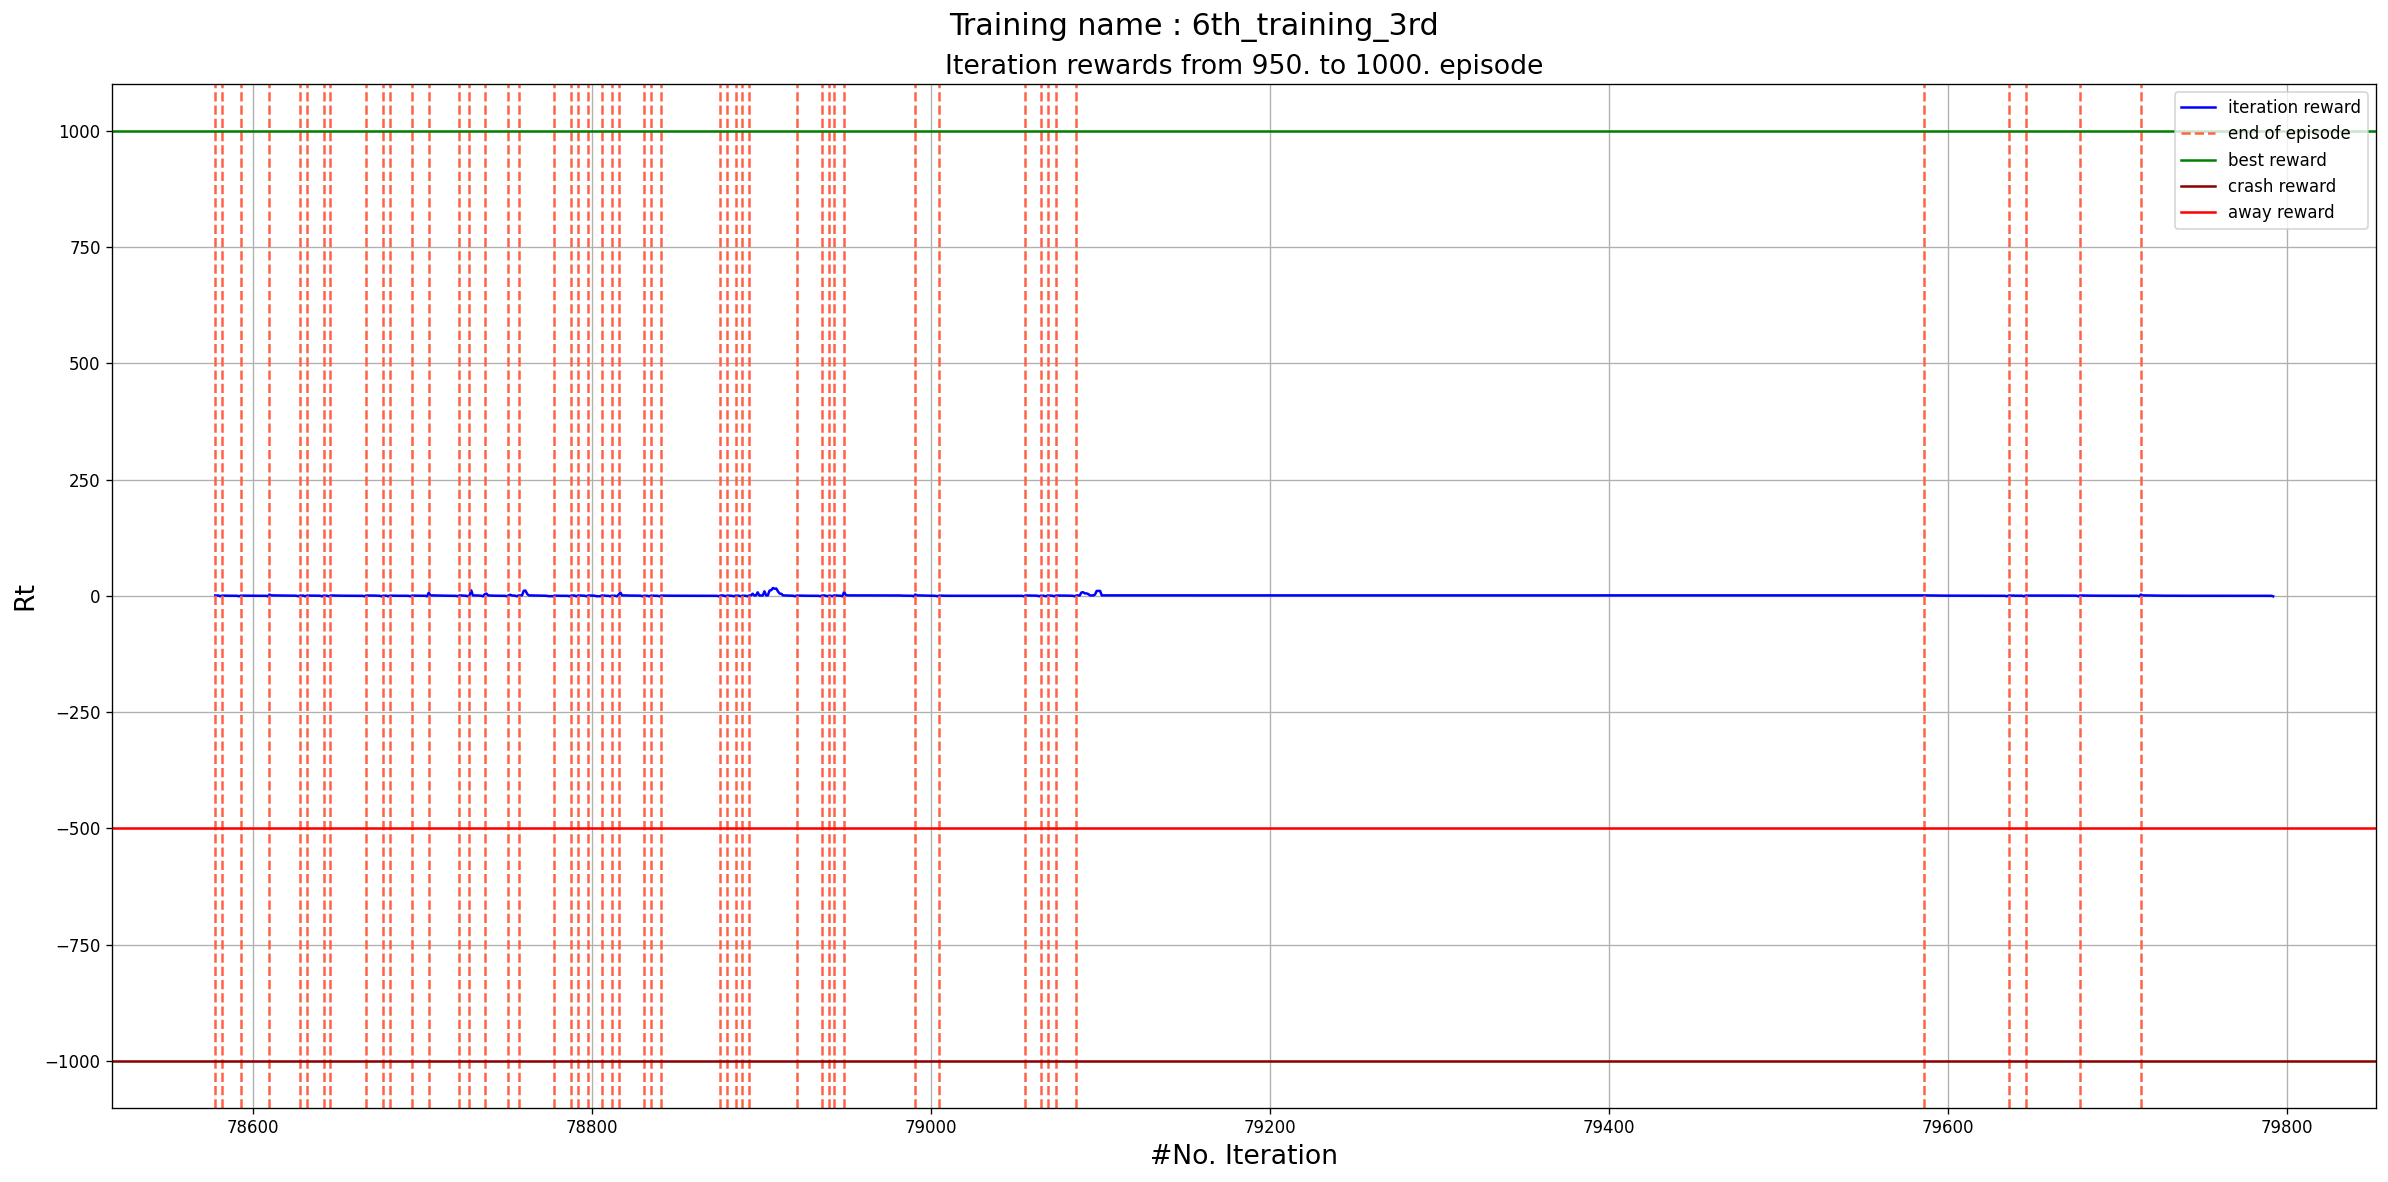

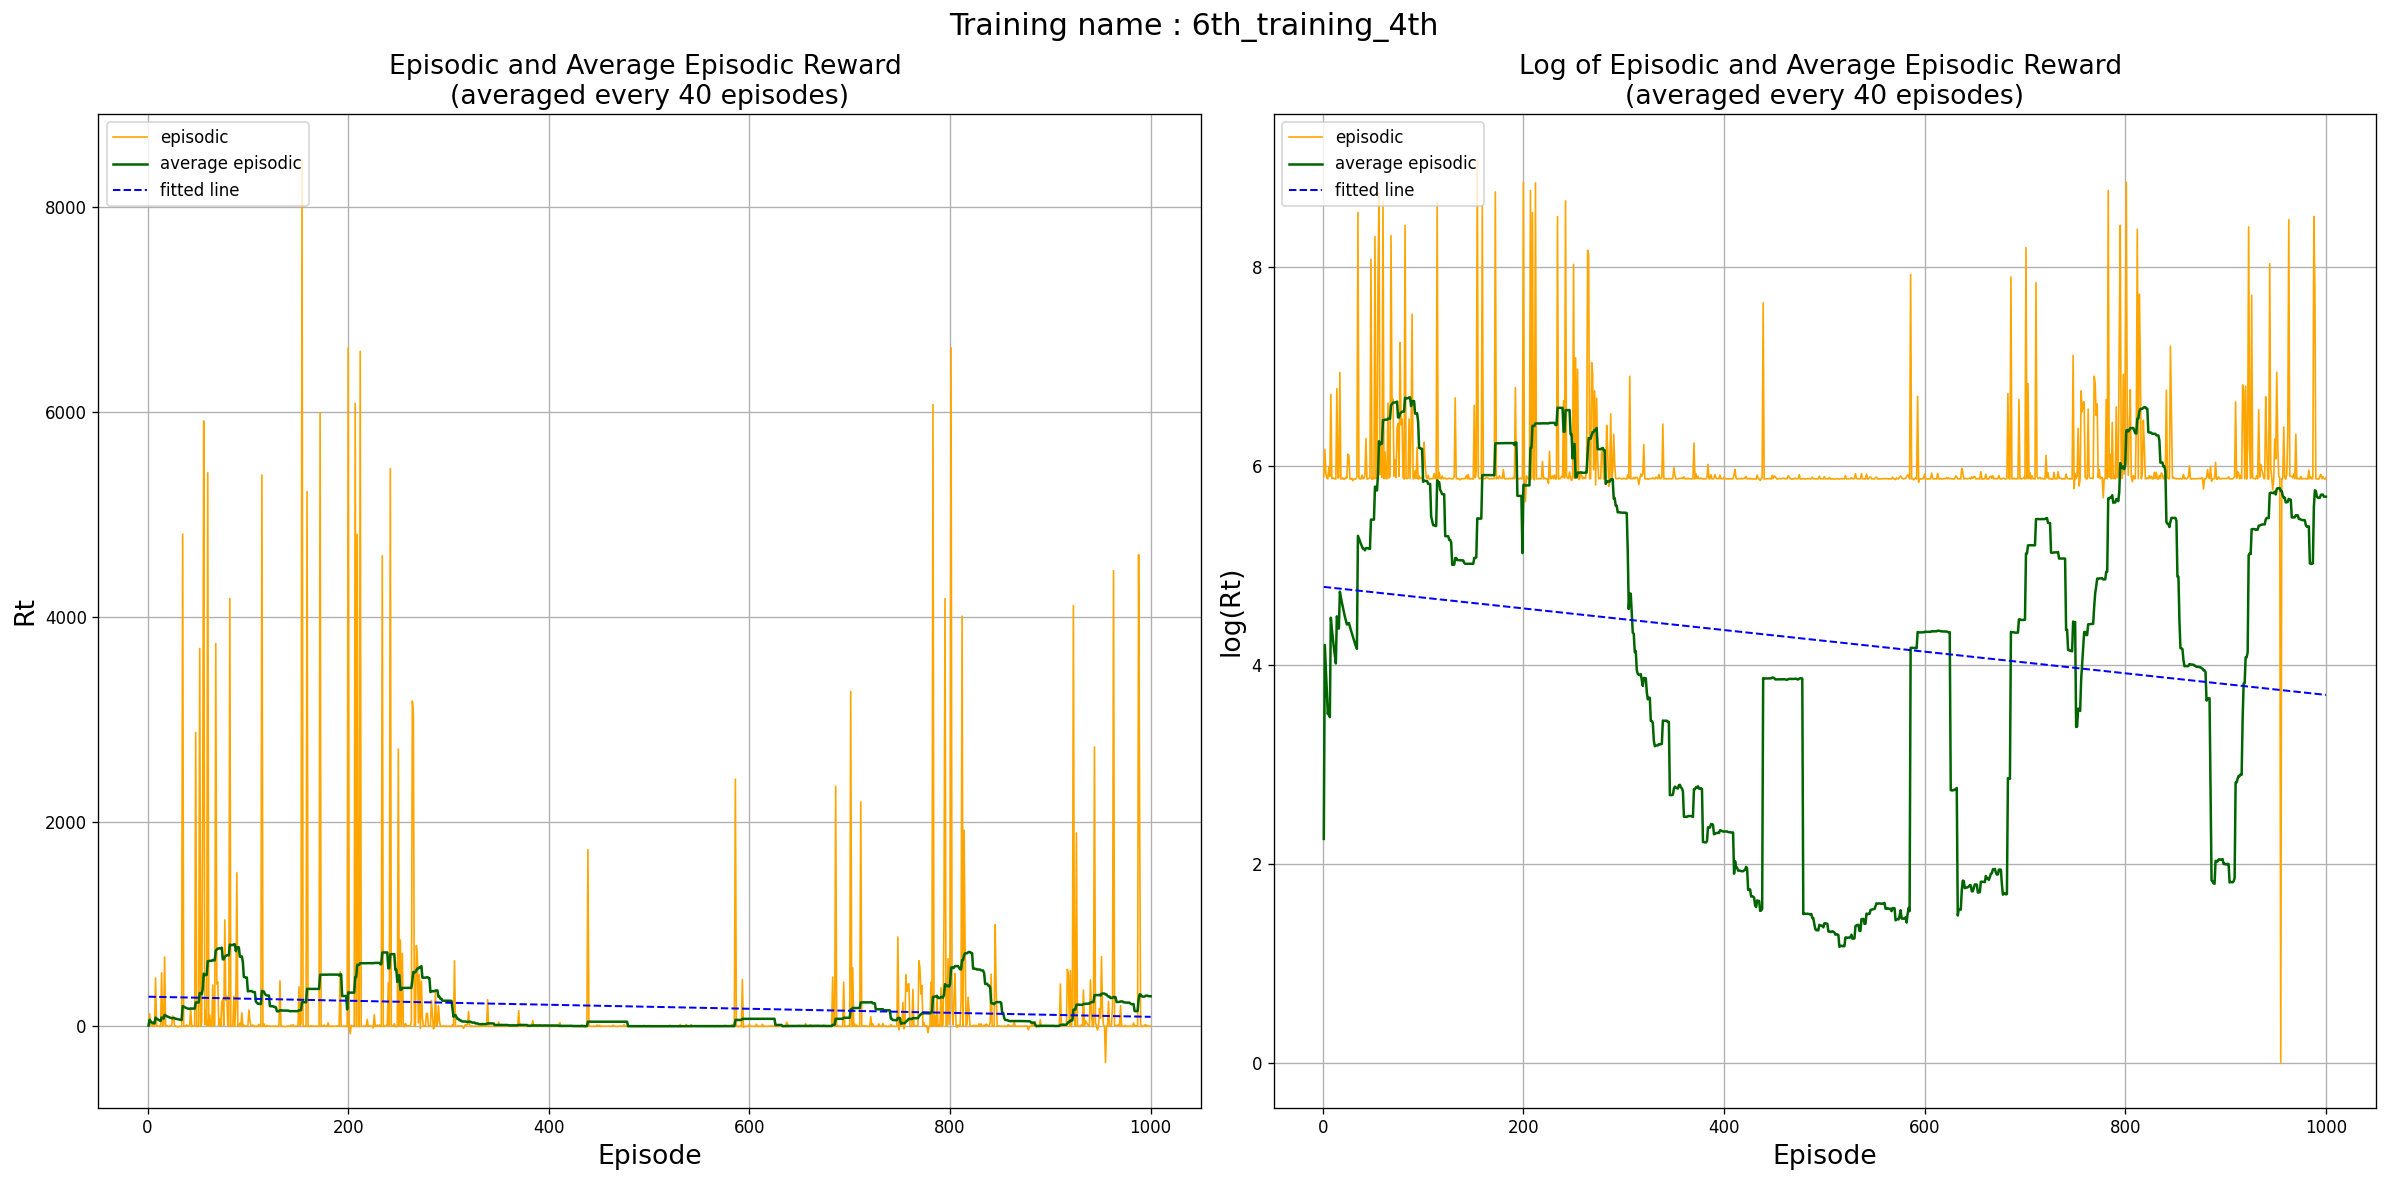

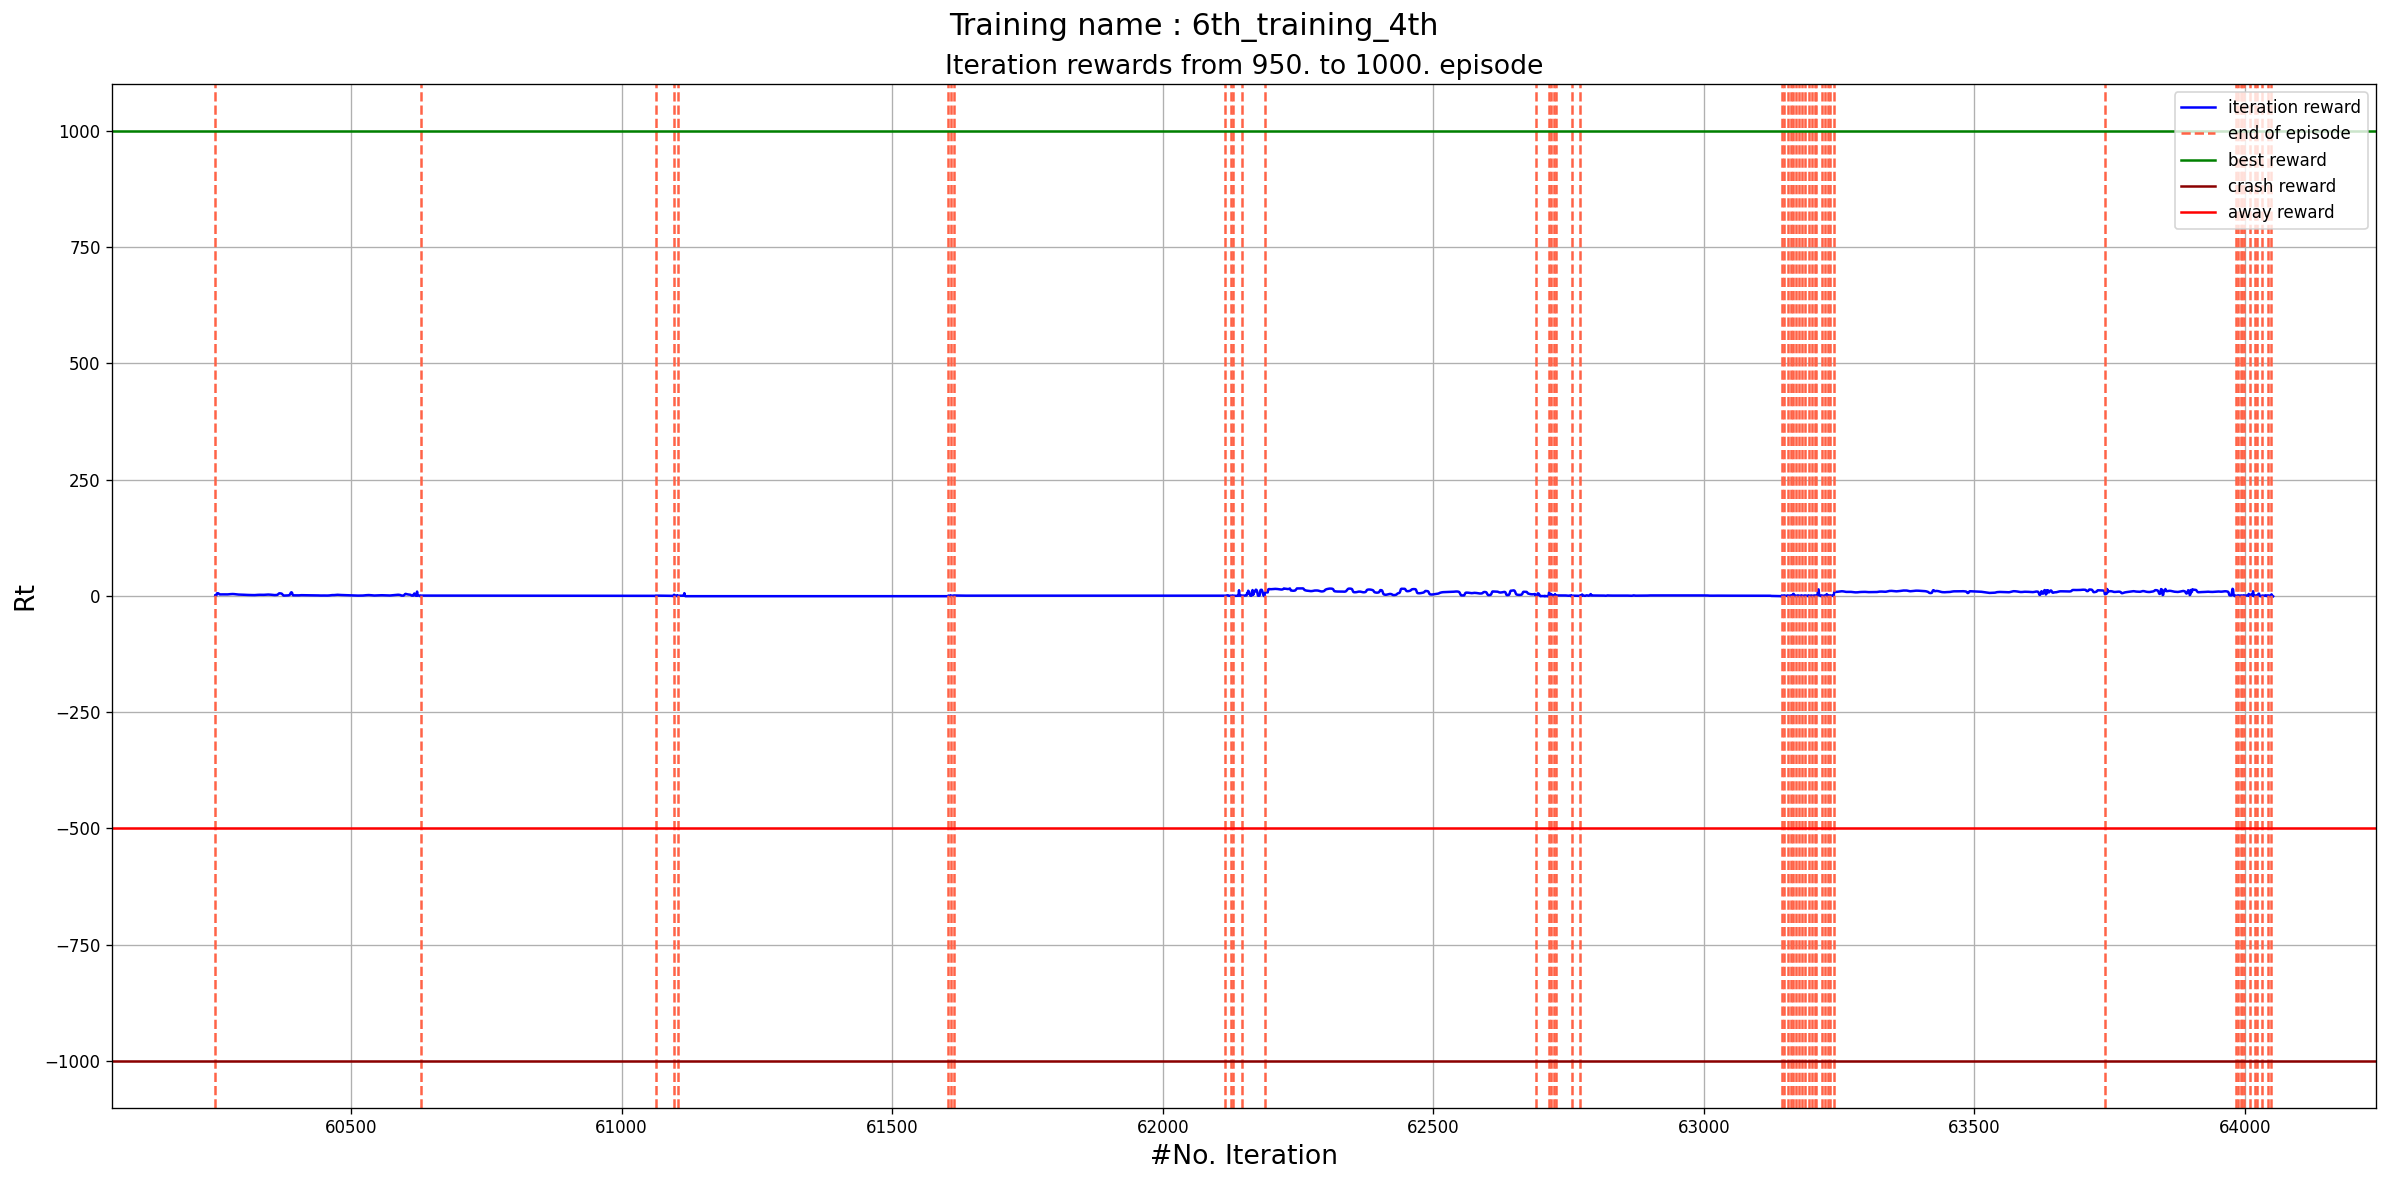

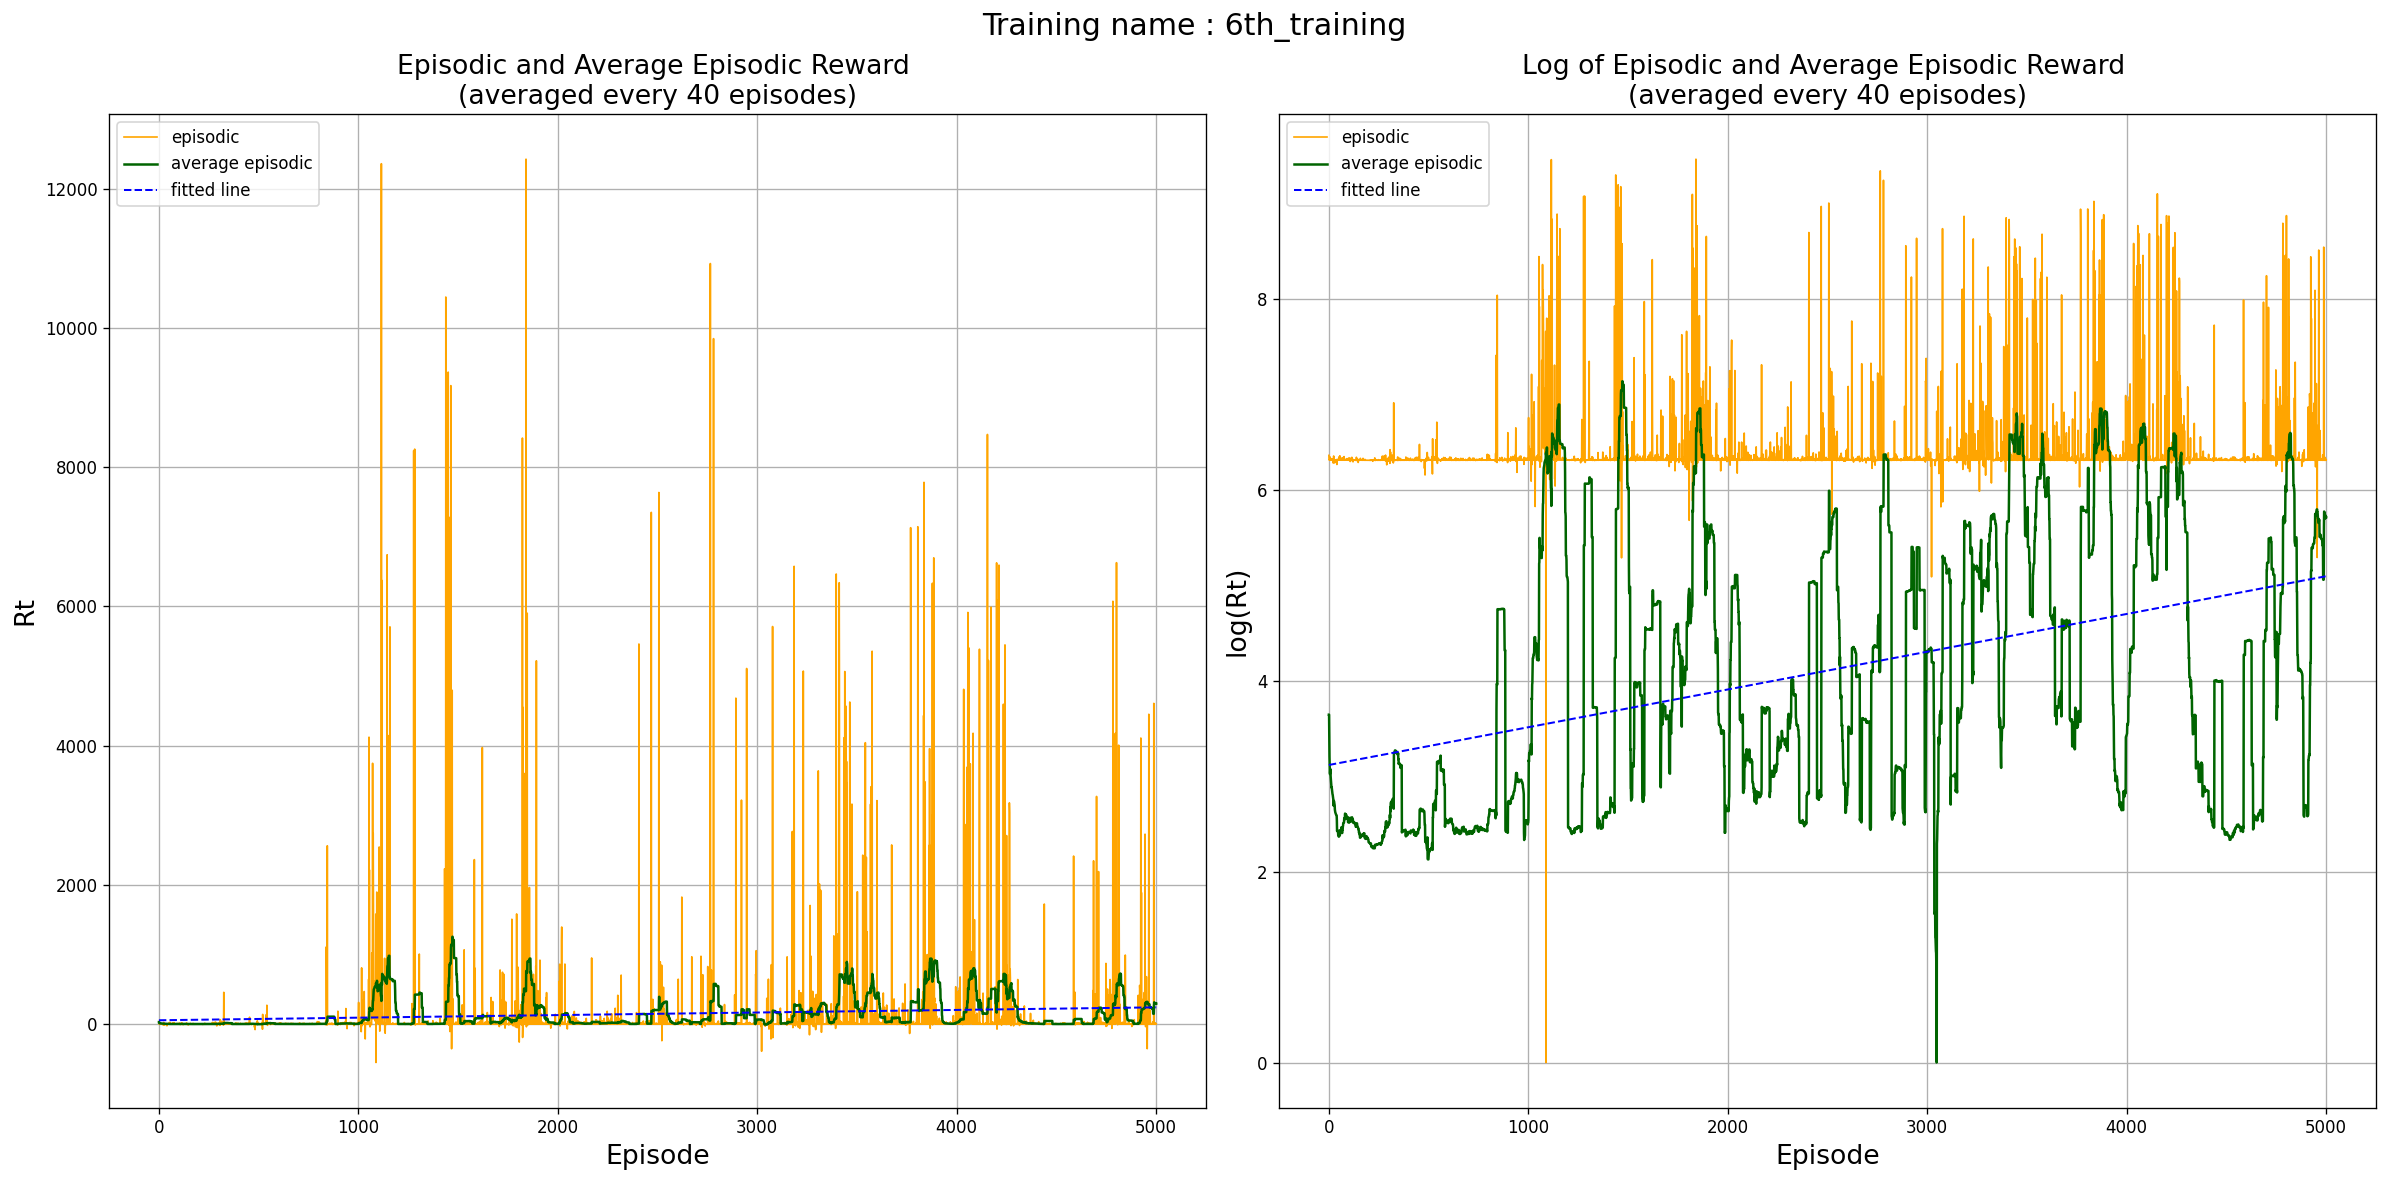

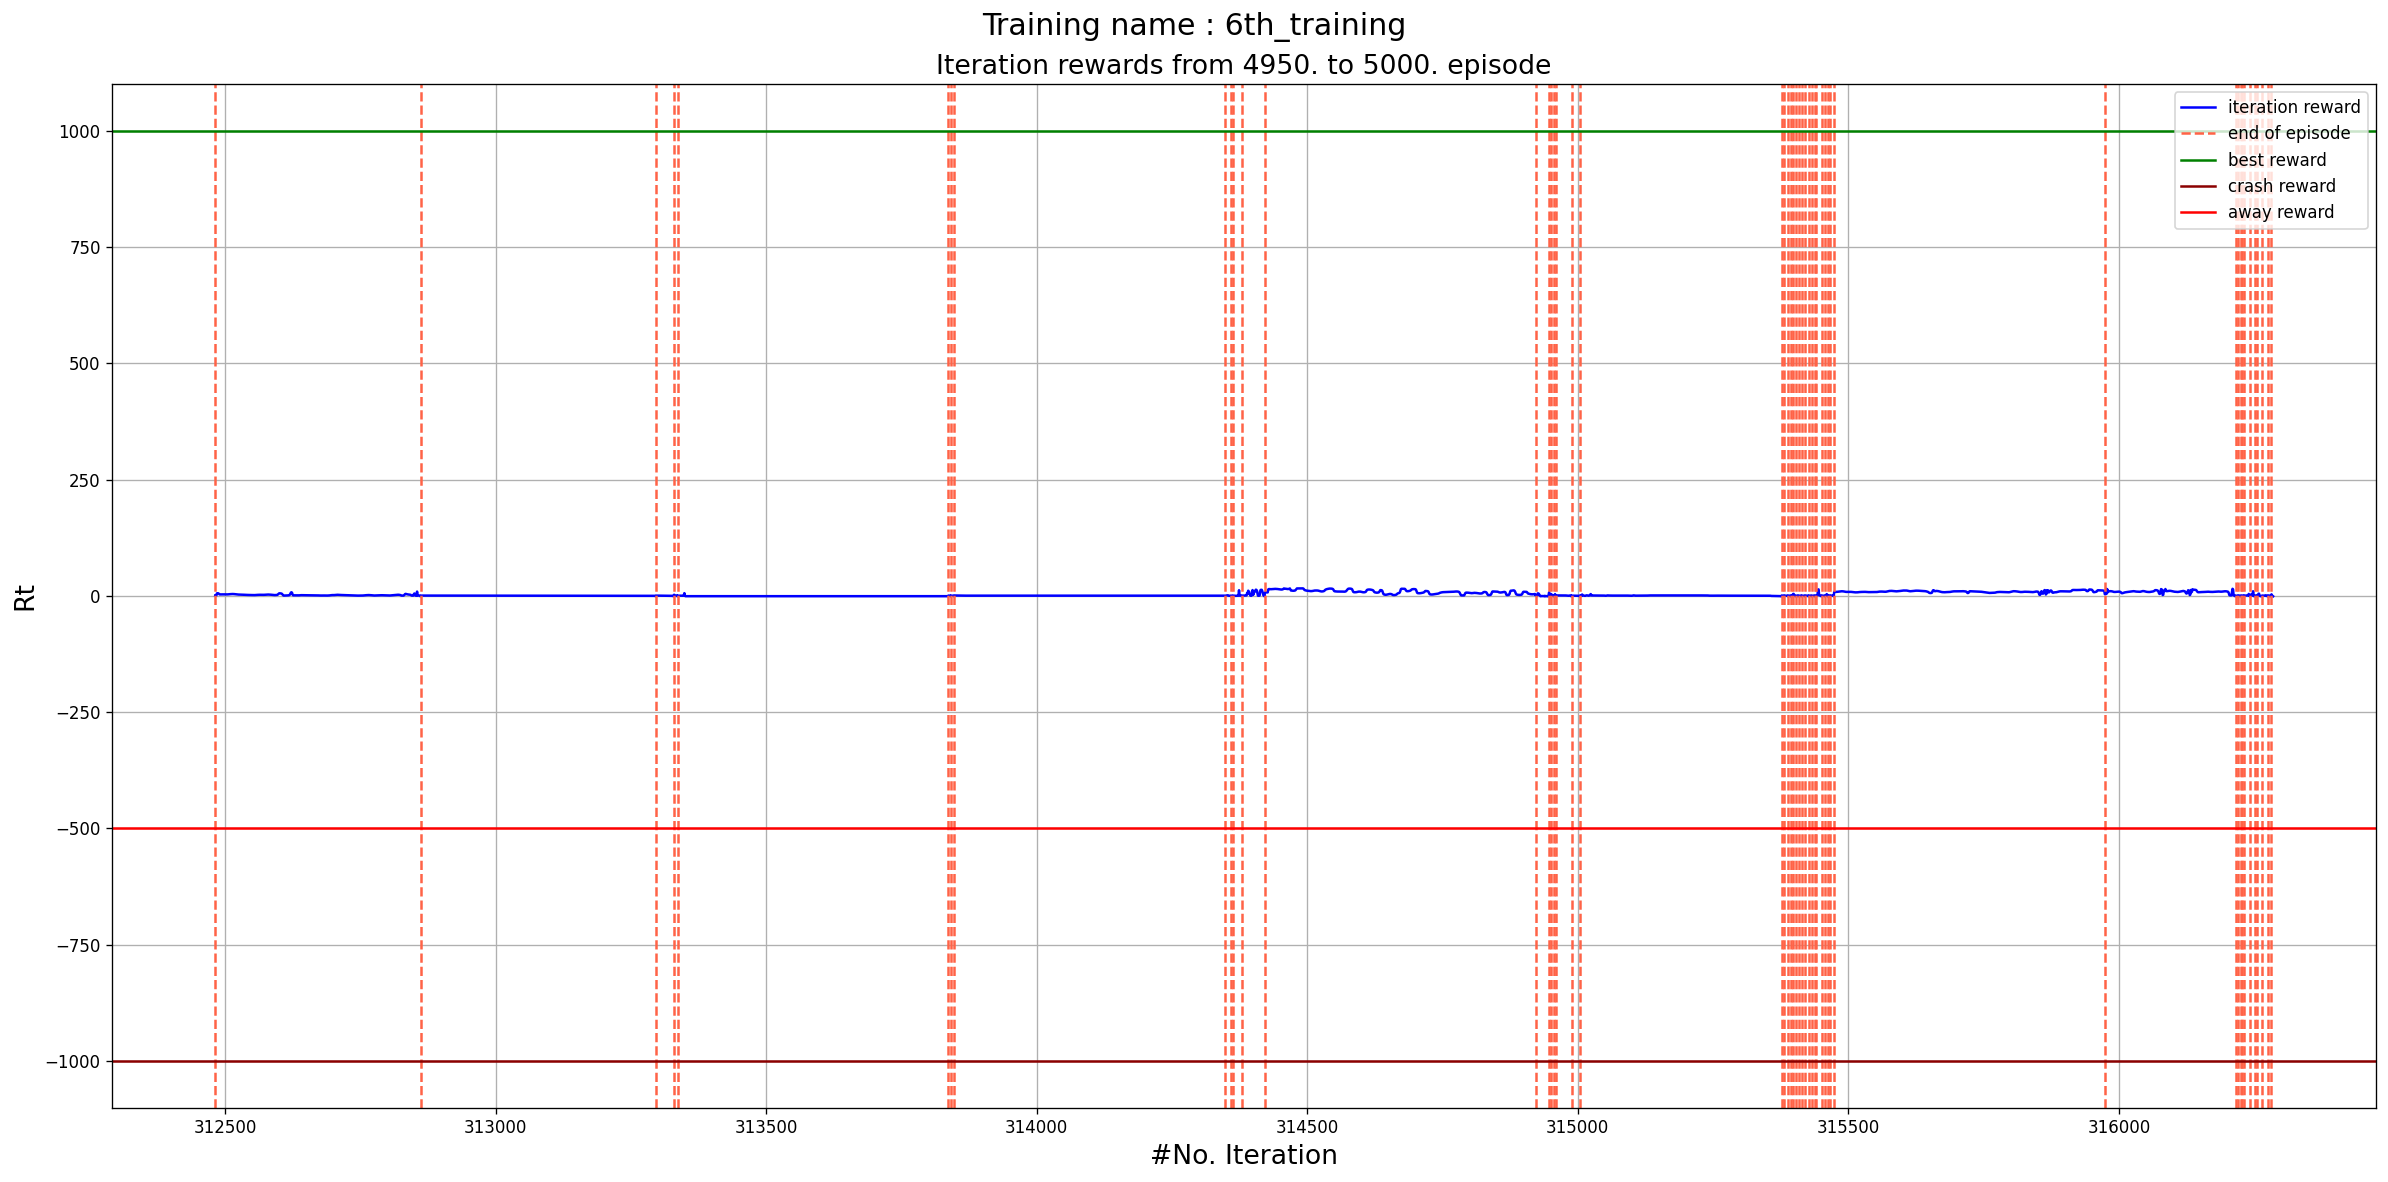

In [27]:
trainings_dict = {
                  '6th_training_1st': 1000,  # total number of episodes
                  '6th_training_2nd': 2000,
                  '6th_training_3rd': 1000,
                  '6th_training_4th': 1000,
                 }

for training_name in trainings_dict.keys():
    data_dict = get_data([training_name])
    plot_results(training_name, data_dict, trainings_dict[training_name])
    
data_dict = get_data(list(trainings_dict.keys()))
plot_results('6th_training', data_dict, np.sum(np.array(list(trainings_dict.values()))), left_index=-51, right_index=-1)

### 7th training results

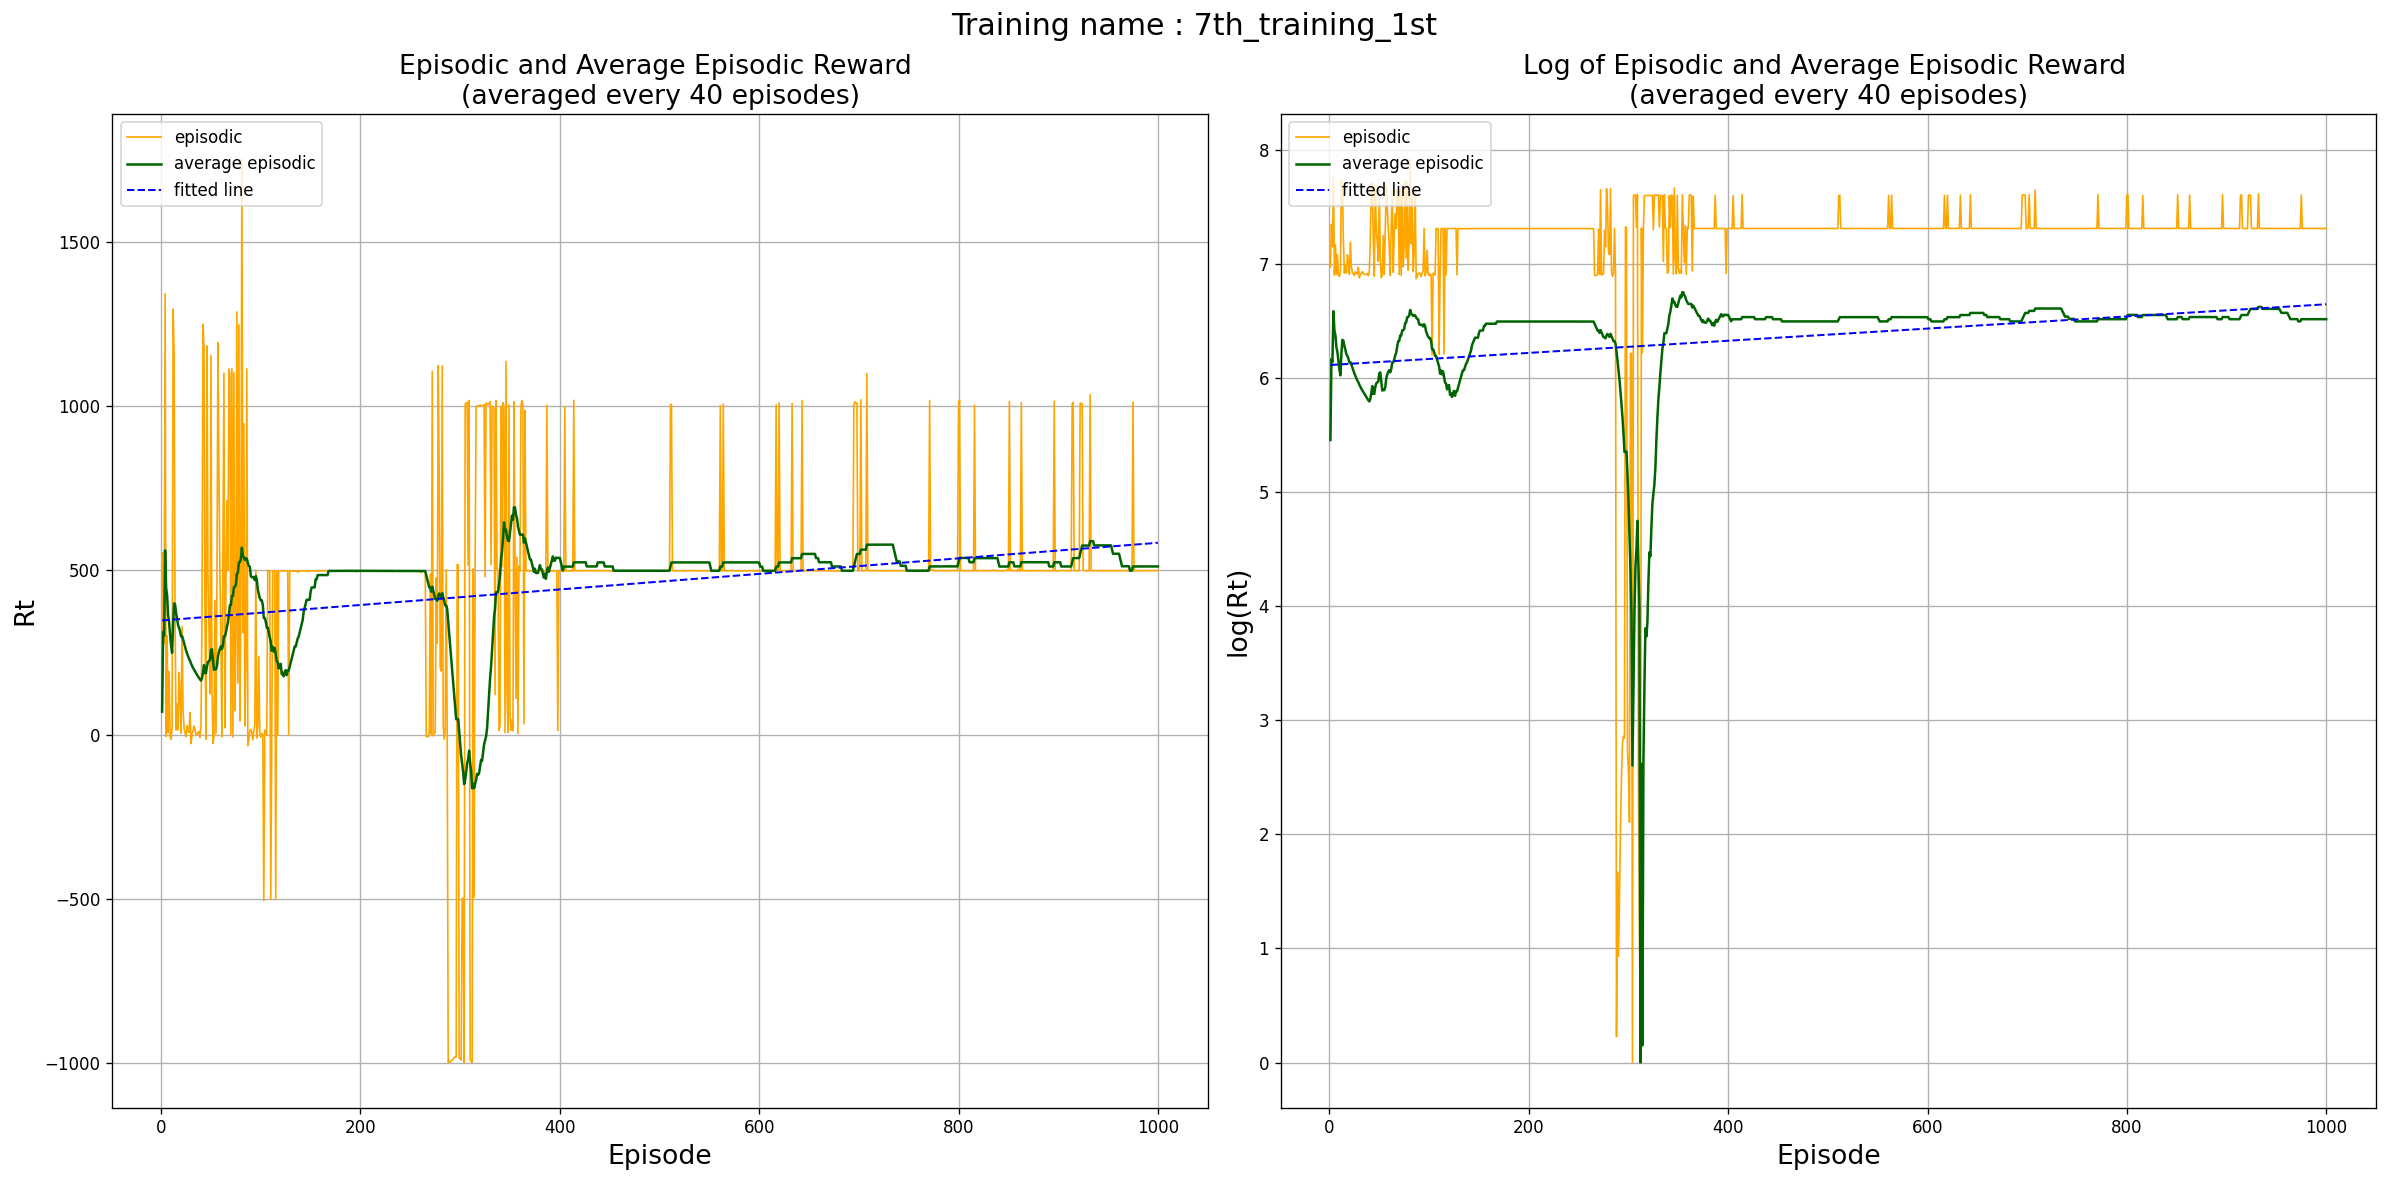

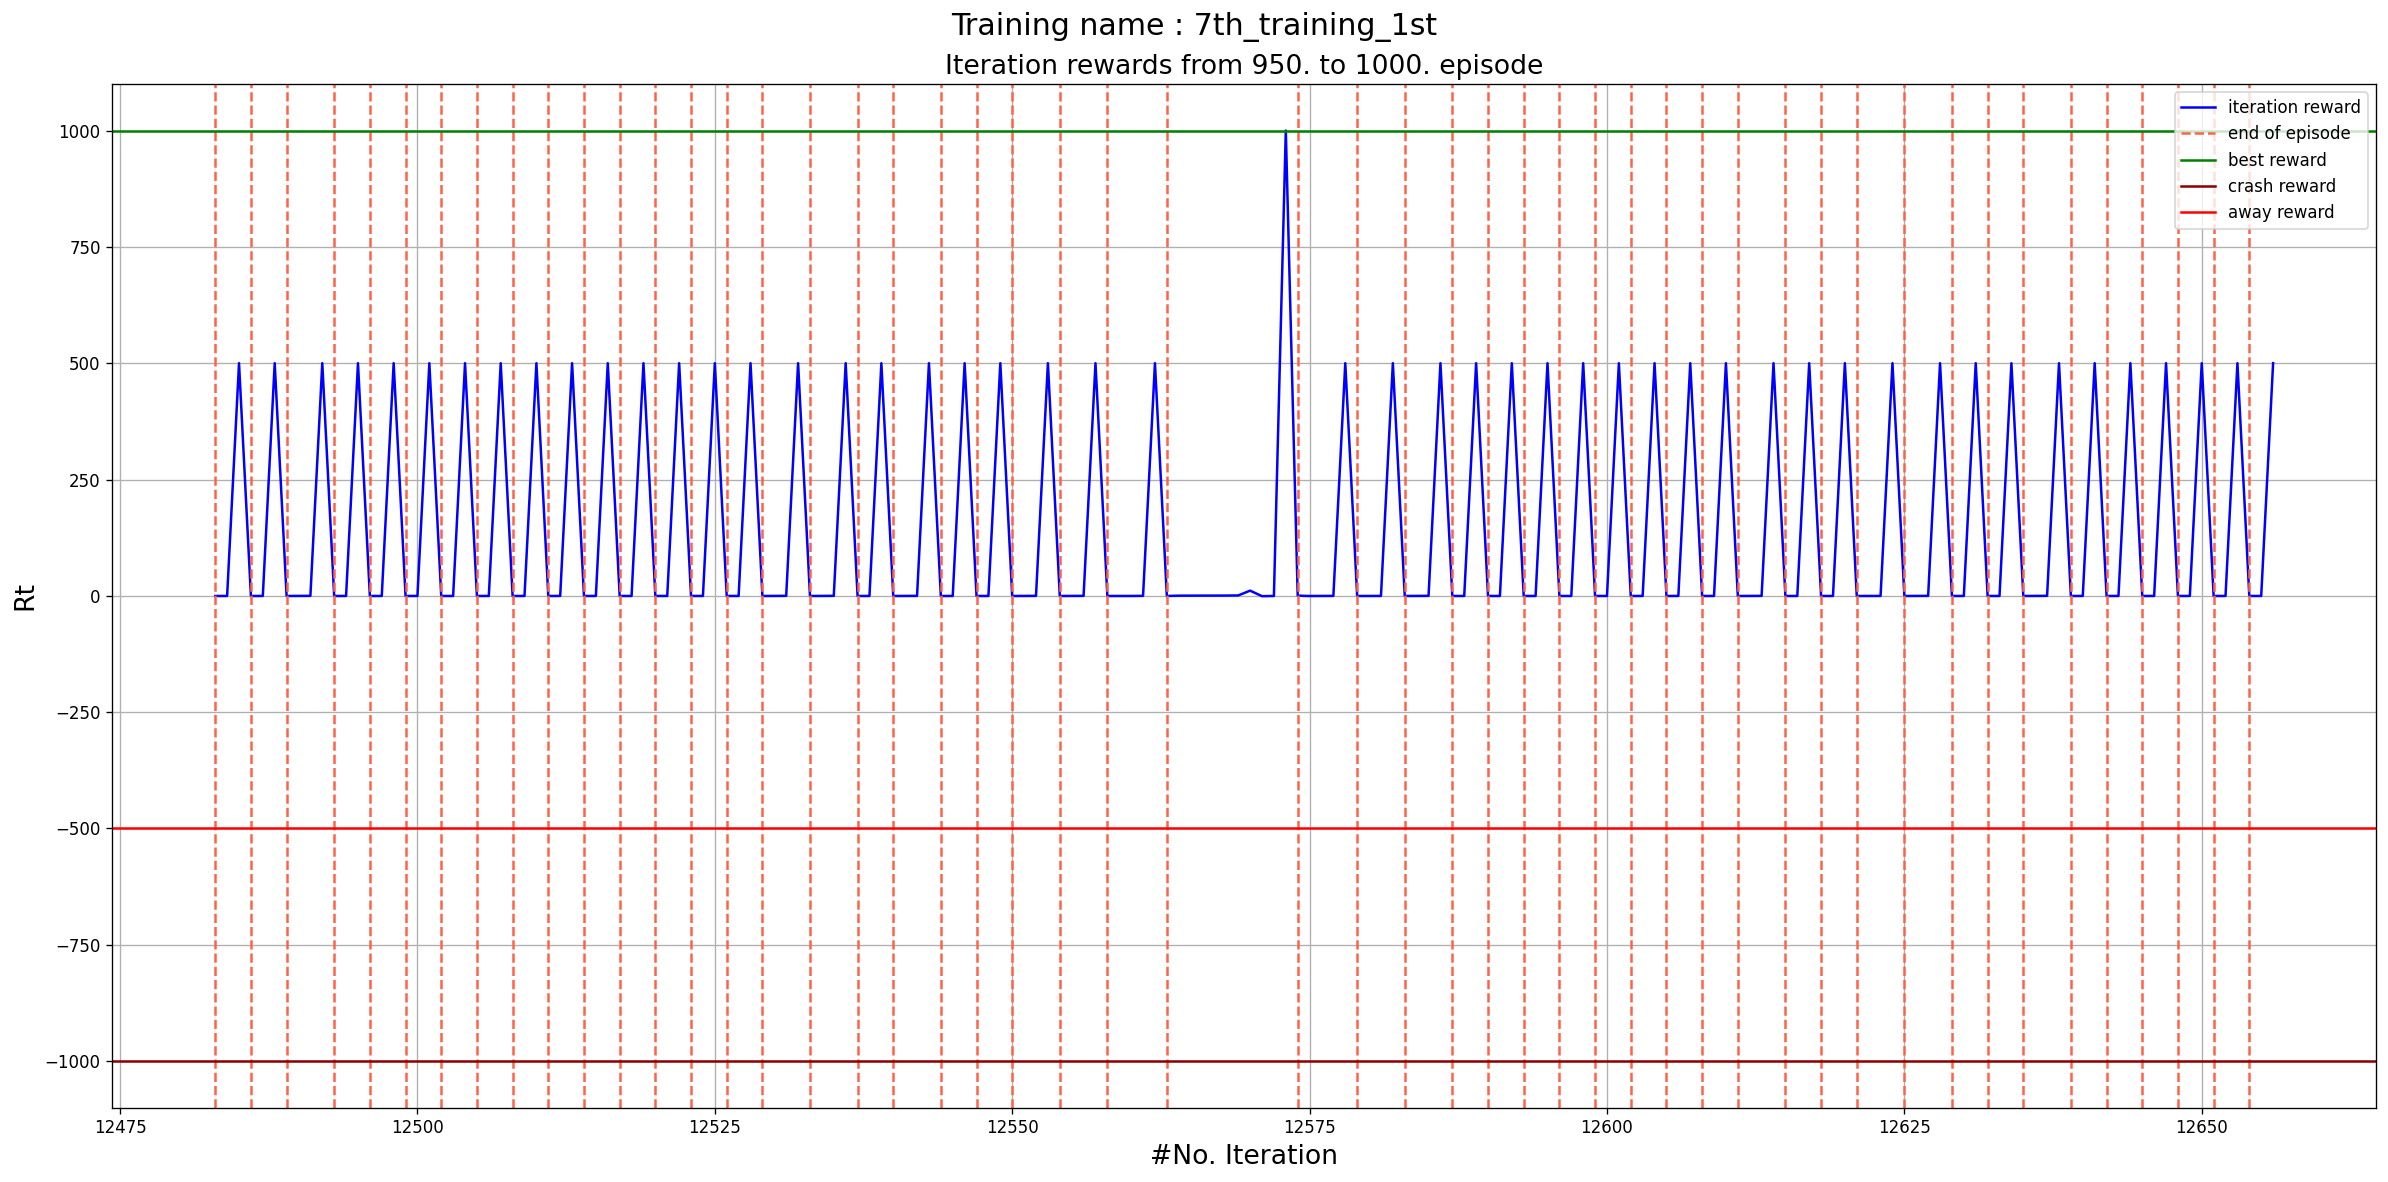

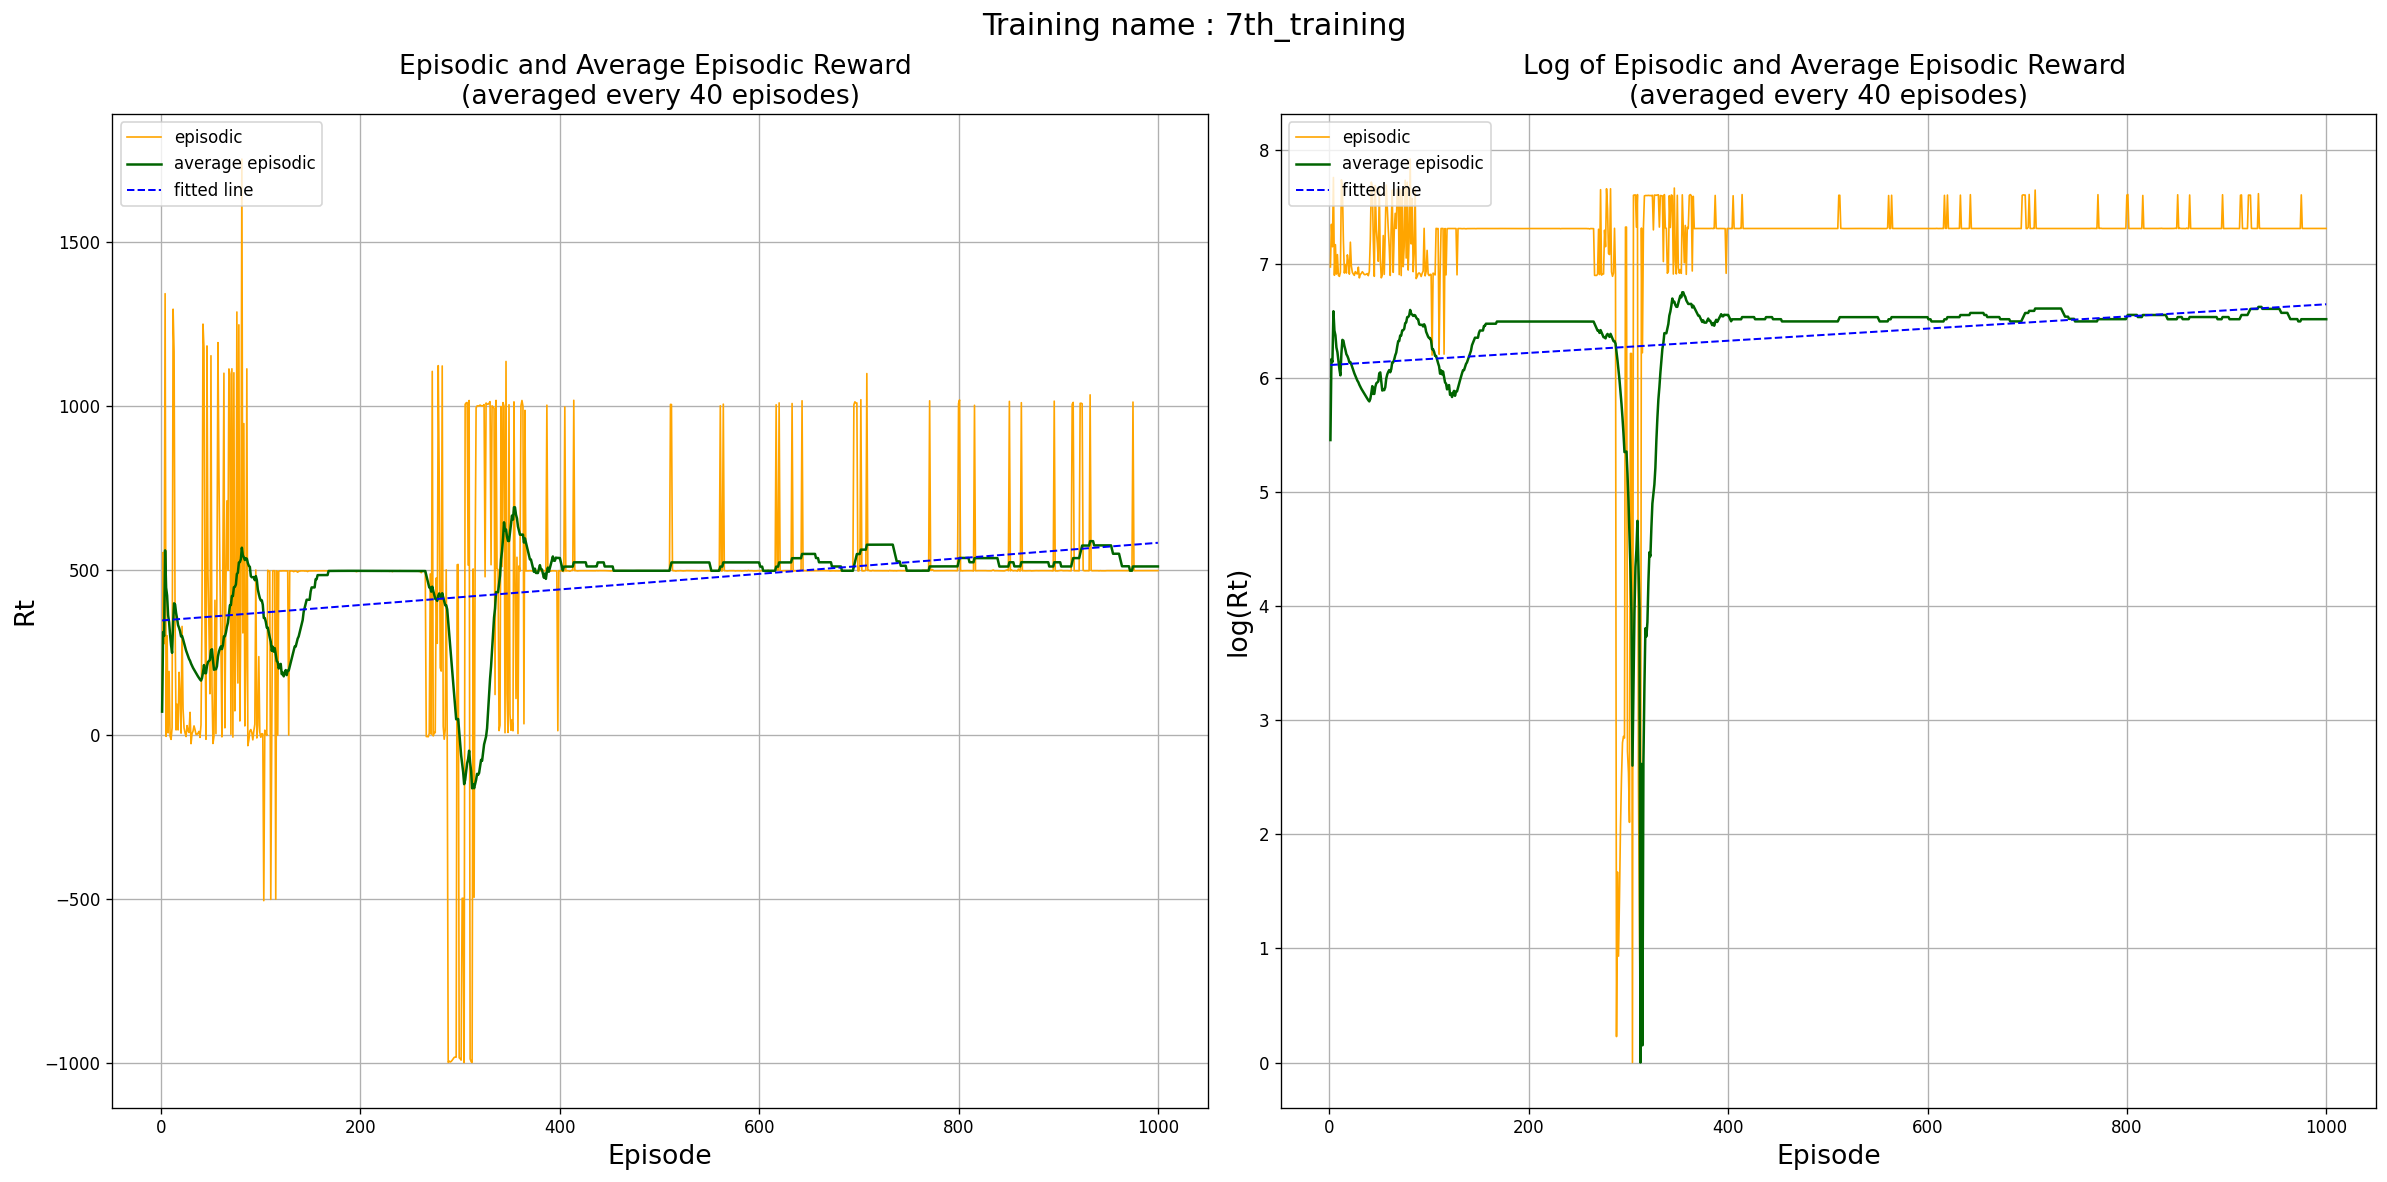

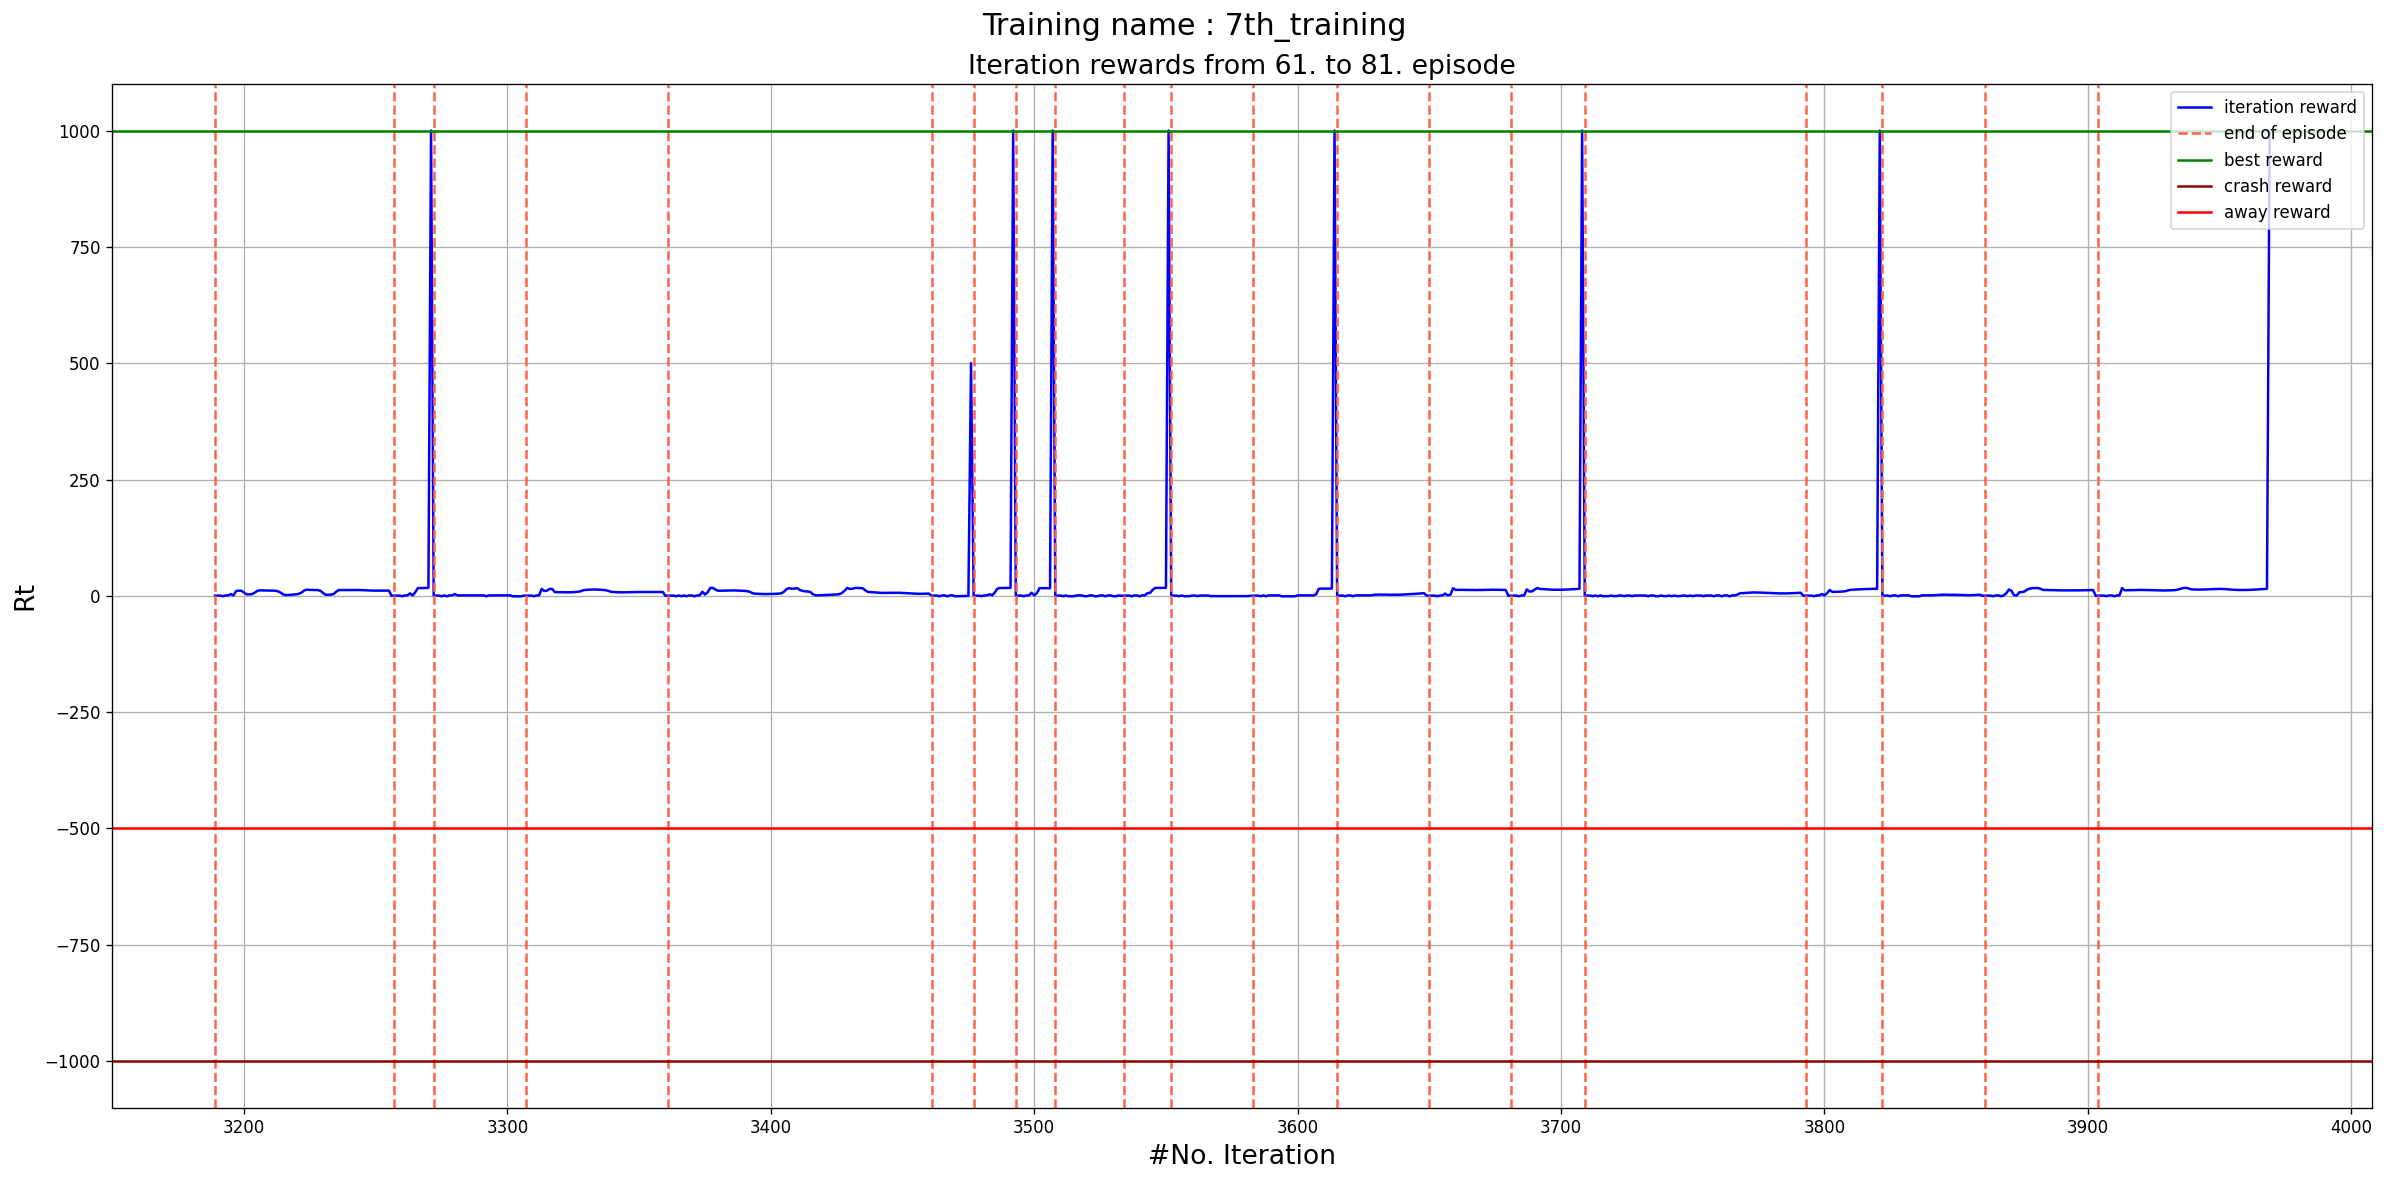

In [28]:
trainings_dict = {
                  '7th_training_1st': 1000, 
                 }

for training_name in trainings_dict.keys():
    data_dict = get_data([training_name])
    plot_results(training_name, data_dict, trainings_dict[training_name])
    
data_dict = get_data(list(trainings_dict.keys()))
plot_results('7th_training', data_dict, np.sum(np.array(list(trainings_dict.values()))), left_index=60, right_index=80)